In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss
from unet import Unet

### Train on HeLa dataset

In [2]:
def train(num_epochs, batch_size, num_workers):
    transformed_dataset = SegmentationDataset(path_to_images='./datasets/HeLa/01/',
                                              path_to_segm='./datasets/HeLa/01_GT/SEG/', 
                                              transform=transforms.Compose([
                                                  ToTensor(), 
                                                  Normalize()
                                              ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    
    net = network()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(84, 1, 512, 512), requires_grad=True)
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.1)
    
    for epoch in range(num_epochs):
        
        for data in dataloader:
            gt_img = Variable(data['image'])
            idx = data['idx']
            
            optimizer.zero_grad()
            img, segm = net(z_input[idx])
            loss = img_loss(img, gt_img)
            loss.backward()
            optimizer.step()
        

In [ ]:
train(1, 2, 1)

### circles example

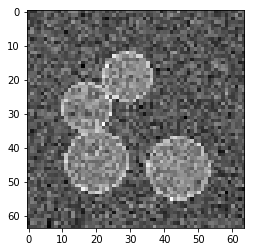

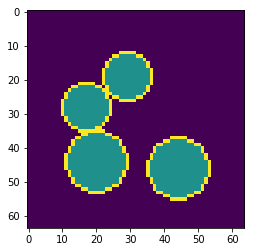

In [3]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
x, y = predata.get_train_batch(1)
plt.imshow(x[0, 0],cmap='gray')
plt.figure()
plt.imshow(y[0])
plt.show()

## Training circles

In [4]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

### Generate train batch

In [7]:
batch_size = 40

In [8]:
np.random.seed(42)
train_images, train_segmentation = predata.get_train_batch(batch_size)

In [9]:
train_images = Variable(torch.from_numpy(train_images).float().cuda(), requires_grad=False)
train_segmentation = Variable(torch.from_numpy(train_segmentation).cuda(), requires_grad=False)

In [10]:
net = Network(num_z_channels=3, num_classes=3).cuda()
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

### create latent variable

In [11]:
torch.manual_seed(42)
z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)

### Training

In [5]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, 3, 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [6]:
without_segmentation = 1

In [7]:
def plot_segmentation(segm, gt_segm, num_epoch):
    segm_numpy = segm.data.cpu().numpy()
    gt_segm_numpy = gt_segm.data.cpu().numpy()
    for i, image in enumerate(segm_numpy):
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(np.argmax(image, 0))
        axarr[0].set_title('Gen segmentation, epoch = {}'.format(num_epoch))
        axarr[1].imshow(gt_segm_numpy[i])
        axarr[1].set_title('Real segmentation')
    plt.show()

In [8]:
def train(net, train_images, train_segmentation, z_input, segm_loss, img_loss, without_segmentation):
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.001)

    loss_epoch = []
    num_epochs = 1000
    print_history = 50
    segmentation_loss = []

    for epoch in range(num_epochs):
        normalize_z(z_input)
        optimizer.zero_grad()   
        img, segm = net(z_input)

        if epoch % print_history == 0:
            plot_segmentation(segm[-1:], 
                              train_segmentation[-1:], 
                              epoch)

        loss = segm_loss(segm[:-without_segmentation], 
                         train_segmentation[:-without_segmentation]) + 1000 * img_loss(img, train_images)
        loss_epoch.append(loss.data)
        segmentation_loss.append(segm_loss(segm[-10:],
                                           train_segmentation[-10:]).data[0])

        loss.backward()
        optimizer.step()
        print('epoch - {}, loss - {}'.format(epoch, loss.data.cpu().numpy()[0]))

    normalize_z(z_input)
    return loss_epoch, segmentation_loss

In [9]:
def generate_and_train(network_class):
    batch_size = 25
    tr_images, tr_segmentation = predata.get_train_batch(batch_size)
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_10, segm_loss_10 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                  img_loss=img_loss, without_segmentation=10, 
                                  train_images=train_images, 
                                  train_segmentation=train_segmentation)
    
    batch_size = 115
    additional_tr_images, additional_tr_segmentation = predata.get_train_batch(90)
    tr_images = np.concatenate((tr_images[:15], additional_tr_images, tr_images[15:]), axis=0)
    tr_segmentation = np.concatenate((tr_segmentation[:15], additional_tr_segmentation, 
                                      tr_segmentation[15:]), axis=0)
    
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_100, segm_loss_100 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                    img_loss=img_loss, without_segmentation=100, 
                                    train_images=train_images, 
                                    train_segmentation=train_segmentation)
    return loss_10, loss_100, segm_loss_10, segm_loss_100

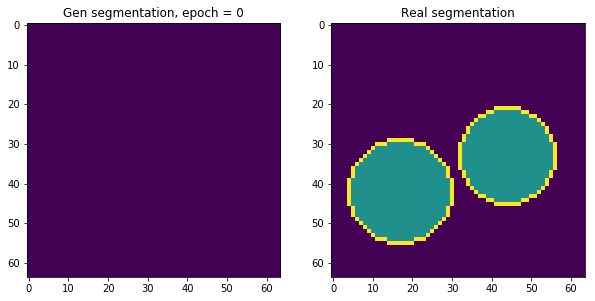

epoch - 0, loss - 6.87568235397
epoch - 1, loss - 25.7822437286
epoch - 2, loss - 6.98602199554
epoch - 3, loss - 6.5875377655
epoch - 4, loss - 6.82738780975
epoch - 5, loss - 6.72454118729
epoch - 6, loss - 6.50114059448
epoch - 7, loss - 6.52453804016
epoch - 8, loss - 6.49144649506
epoch - 9, loss - 6.37174272537
epoch - 10, loss - 6.35305595398
epoch - 11, loss - 6.34811544418
epoch - 12, loss - 6.27602338791
epoch - 13, loss - 6.18825626373
epoch - 14, loss - 6.1472902298
epoch - 15, loss - 6.0965795517
epoch - 16, loss - 6.08230638504
epoch - 17, loss - 6.11773729324
epoch - 18, loss - 6.08475732803
epoch - 19, loss - 6.08843231201
epoch - 20, loss - 6.03314113617
epoch - 21, loss - 6.01691770554
epoch - 22, loss - 5.99313020706
epoch - 23, loss - 5.98035430908
epoch - 24, loss - 5.97777700424
epoch - 25, loss - 5.96085786819
epoch - 26, loss - 5.96279716492
epoch - 27, loss - 5.94690084457
epoch - 28, loss - 5.93834114075
epoch - 29, loss - 5.92445850372
epoch - 30, loss - 5.90

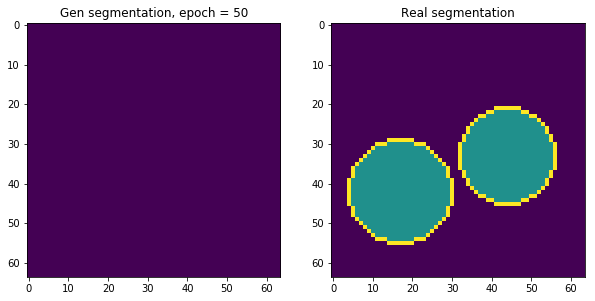

epoch - 50, loss - 5.81185770035
epoch - 51, loss - 5.79588460922
epoch - 52, loss - 5.76626396179
epoch - 53, loss - 5.78229188919
epoch - 54, loss - 5.75484132767
epoch - 55, loss - 5.74164247513
epoch - 56, loss - 5.74826002121
epoch - 57, loss - 5.71857976913
epoch - 58, loss - 5.72093963623
epoch - 59, loss - 5.69866132736
epoch - 60, loss - 5.69167661667
epoch - 61, loss - 5.66352319717
epoch - 62, loss - 5.66678476334
epoch - 63, loss - 5.64009952545
epoch - 64, loss - 5.62743377686
epoch - 65, loss - 5.6313867569
epoch - 66, loss - 5.66589355469
epoch - 67, loss - 5.84383583069
epoch - 68, loss - 5.80612897873
epoch - 69, loss - 5.58443164825
epoch - 70, loss - 5.63225078583
epoch - 71, loss - 5.62364292145
epoch - 72, loss - 5.54233217239
epoch - 73, loss - 5.60291194916
epoch - 74, loss - 5.50884246826
epoch - 75, loss - 5.56543159485
epoch - 76, loss - 5.48822975159
epoch - 77, loss - 5.50271701813
epoch - 78, loss - 5.47101449966
epoch - 79, loss - 5.42650032043
epoch - 80,

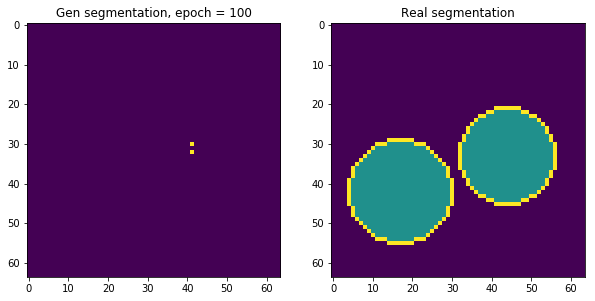

epoch - 100, loss - 5.08009004593
epoch - 101, loss - 5.05301141739
epoch - 102, loss - 5.08703136444
epoch - 103, loss - 4.89790439606
epoch - 104, loss - 4.85521459579
epoch - 105, loss - 4.84901046753
epoch - 106, loss - 4.66896009445
epoch - 107, loss - 4.72148513794
epoch - 108, loss - 4.56341648102
epoch - 109, loss - 4.60887432098
epoch - 110, loss - 4.48093509674
epoch - 111, loss - 4.50795173645
epoch - 112, loss - 4.39460897446
epoch - 113, loss - 4.39844322205
epoch - 114, loss - 4.32314586639
epoch - 115, loss - 4.28292131424
epoch - 116, loss - 4.2309885025
epoch - 117, loss - 4.17110967636
epoch - 118, loss - 4.14663028717
epoch - 119, loss - 4.07511997223
epoch - 120, loss - 4.08204889297
epoch - 121, loss - 3.99475693703
epoch - 122, loss - 3.97579836845
epoch - 123, loss - 3.93486666679
epoch - 124, loss - 3.8810801506
epoch - 125, loss - 3.87542080879
epoch - 126, loss - 3.81819963455
epoch - 127, loss - 3.80347371101
epoch - 128, loss - 3.79867959023
epoch - 129, los

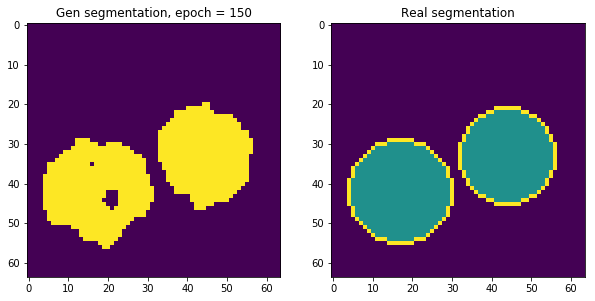

epoch - 150, loss - 3.42207479477
epoch - 151, loss - 3.41395449638
epoch - 152, loss - 3.4026222229
epoch - 153, loss - 3.38920903206
epoch - 154, loss - 3.37703156471
epoch - 155, loss - 3.36672282219
epoch - 156, loss - 3.35834550858
epoch - 157, loss - 3.35103440285
epoch - 158, loss - 3.34410238266
epoch - 159, loss - 3.33835840225
epoch - 160, loss - 3.33218693733
epoch - 161, loss - 3.32597303391
epoch - 162, loss - 3.31682515144
epoch - 163, loss - 3.30544161797
epoch - 164, loss - 3.29060959816
epoch - 165, loss - 3.27579951286
epoch - 166, loss - 3.26386499405
epoch - 167, loss - 3.25571870804
epoch - 168, loss - 3.25013399124
epoch - 169, loss - 3.24675178528
epoch - 170, loss - 3.24810266495
epoch - 171, loss - 3.25190925598
epoch - 172, loss - 3.25466275215
epoch - 173, loss - 3.24620270729
epoch - 174, loss - 3.22104501724
epoch - 175, loss - 3.18876338005
epoch - 176, loss - 3.17277193069
epoch - 177, loss - 3.17443346977
epoch - 178, loss - 3.1759531498
epoch - 179, los

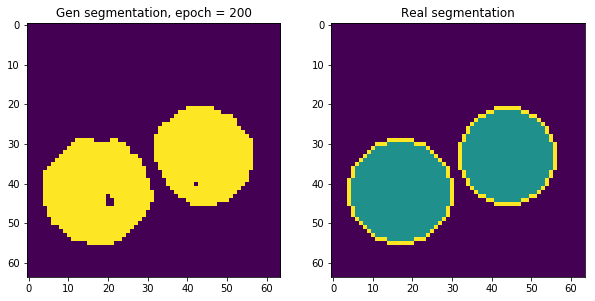

epoch - 200, loss - 2.95093035698
epoch - 201, loss - 2.94523692131
epoch - 202, loss - 2.93693757057
epoch - 203, loss - 2.92161417007
epoch - 204, loss - 2.9107375145
epoch - 205, loss - 2.89946722984
epoch - 206, loss - 2.89061808586
epoch - 207, loss - 2.88389611244
epoch - 208, loss - 2.87450408936
epoch - 209, loss - 2.86540174484
epoch - 210, loss - 2.8559691906
epoch - 211, loss - 2.84696054459
epoch - 212, loss - 2.84025120735
epoch - 213, loss - 2.83503913879
epoch - 214, loss - 2.83684659004
epoch - 215, loss - 2.85127973557
epoch - 216, loss - 2.87018537521
epoch - 217, loss - 2.87455701828
epoch - 218, loss - 2.86123847961
epoch - 219, loss - 2.80399012566
epoch - 220, loss - 2.76353335381
epoch - 221, loss - 2.77022027969
epoch - 222, loss - 2.78903365135
epoch - 223, loss - 2.78136014938
epoch - 224, loss - 2.7411043644
epoch - 225, loss - 2.72124838829
epoch - 226, loss - 2.73225331306
epoch - 227, loss - 2.73337554932
epoch - 228, loss - 2.71810722351
epoch - 229, loss

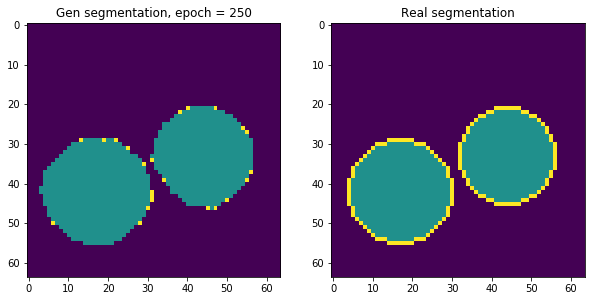

epoch - 250, loss - 2.58002948761
epoch - 251, loss - 2.53067803383
epoch - 252, loss - 2.59734988213
epoch - 253, loss - 2.55366849899
epoch - 254, loss - 2.49771881104
epoch - 255, loss - 2.53118920326
epoch - 256, loss - 2.53232717514
epoch - 257, loss - 2.4707660675
epoch - 258, loss - 2.48641514778
epoch - 259, loss - 2.49974250793
epoch - 260, loss - 2.48600888252
epoch - 261, loss - 2.43808317184
epoch - 262, loss - 2.46655321121
epoch - 263, loss - 2.47527766228
epoch - 264, loss - 2.42983579636
epoch - 265, loss - 2.41936731339
epoch - 266, loss - 2.43846726418
epoch - 267, loss - 2.42812228203
epoch - 268, loss - 2.38583946228
epoch - 269, loss - 2.38961744308
epoch - 270, loss - 2.39733743668
epoch - 271, loss - 2.39497280121
epoch - 272, loss - 2.35882043839
epoch - 273, loss - 2.353941679
epoch - 274, loss - 2.35088300705
epoch - 275, loss - 2.35622835159
epoch - 276, loss - 2.33701467514
epoch - 277, loss - 2.32122039795
epoch - 278, loss - 2.30641961098
epoch - 279, loss

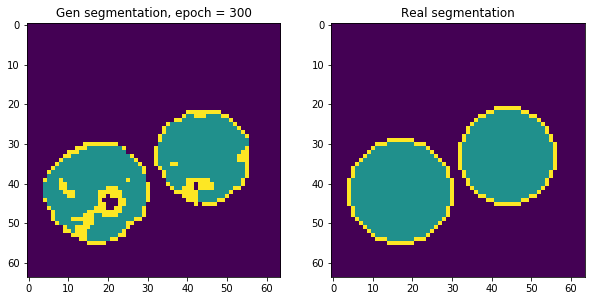

epoch - 300, loss - 2.44395446777
epoch - 301, loss - 2.50308299065
epoch - 302, loss - 2.45627689362
epoch - 303, loss - 2.1369035244
epoch - 304, loss - 2.26155686378
epoch - 305, loss - 2.43915891647
epoch - 306, loss - 2.12979221344
epoch - 307, loss - 2.27949213982
epoch - 308, loss - 2.31469106674
epoch - 309, loss - 2.11585068703
epoch - 310, loss - 2.32693576813
epoch - 311, loss - 2.1407418251
epoch - 312, loss - 2.16426420212
epoch - 313, loss - 2.19714975357
epoch - 314, loss - 2.06661534309
epoch - 315, loss - 2.14529585838
epoch - 316, loss - 2.07071638107
epoch - 317, loss - 2.08565473557
epoch - 318, loss - 2.08173370361
epoch - 319, loss - 2.0309574604
epoch - 320, loss - 2.07166051865
epoch - 321, loss - 2.02180600166
epoch - 322, loss - 2.02065253258
epoch - 323, loss - 2.02992463112
epoch - 324, loss - 1.98084580898
epoch - 325, loss - 1.99500870705
epoch - 326, loss - 1.97518730164
epoch - 327, loss - 1.96000230312
epoch - 328, loss - 1.9660513401
epoch - 329, loss 

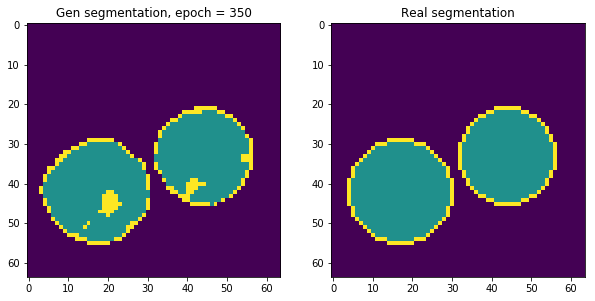

epoch - 350, loss - 1.77911949158
epoch - 351, loss - 1.7631649971
epoch - 352, loss - 1.75495052338
epoch - 353, loss - 1.75294089317
epoch - 354, loss - 1.74243247509
epoch - 355, loss - 1.73329913616
epoch - 356, loss - 1.72459304333
epoch - 357, loss - 1.71406805515
epoch - 358, loss - 1.70640420914
epoch - 359, loss - 1.70169019699
epoch - 360, loss - 1.68890452385
epoch - 361, loss - 1.69298839569
epoch - 362, loss - 1.69111394882
epoch - 363, loss - 1.68581557274
epoch - 364, loss - 1.68328917027
epoch - 365, loss - 1.67541348934
epoch - 366, loss - 1.68769717216
epoch - 367, loss - 1.67692160606
epoch - 368, loss - 1.67967939377
epoch - 369, loss - 1.64334881306
epoch - 370, loss - 1.62834966183
epoch - 371, loss - 1.61193907261
epoch - 372, loss - 1.60479390621
epoch - 373, loss - 1.59199500084
epoch - 374, loss - 1.59271538258
epoch - 375, loss - 1.58436882496
epoch - 376, loss - 1.5939437151
epoch - 377, loss - 1.60321748257
epoch - 378, loss - 1.60235416889
epoch - 379, los

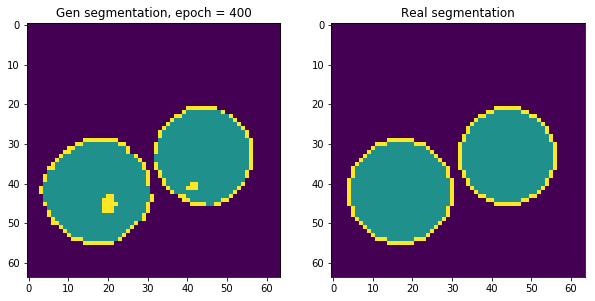

epoch - 400, loss - 1.46090400219
epoch - 401, loss - 1.472245574
epoch - 402, loss - 1.4492919445
epoch - 403, loss - 1.43631827831
epoch - 404, loss - 1.38482177258
epoch - 405, loss - 1.3734190464
epoch - 406, loss - 1.36629271507
epoch - 407, loss - 1.38587832451
epoch - 408, loss - 1.39280998707
epoch - 409, loss - 1.37804949284
epoch - 410, loss - 1.35903847218
epoch - 411, loss - 1.33199489117
epoch - 412, loss - 1.31234955788
epoch - 413, loss - 1.31298243999
epoch - 414, loss - 1.31673073769
epoch - 415, loss - 1.33295857906
epoch - 416, loss - 1.32035934925
epoch - 417, loss - 1.31338202953
epoch - 418, loss - 1.29479777813
epoch - 419, loss - 1.27206802368
epoch - 420, loss - 1.26021659374
epoch - 421, loss - 1.24344241619
epoch - 422, loss - 1.23968732357
epoch - 423, loss - 1.2363781929
epoch - 424, loss - 1.23847329617
epoch - 425, loss - 1.23665130138
epoch - 426, loss - 1.25241529942
epoch - 427, loss - 1.24983620644
epoch - 428, loss - 1.27047431469
epoch - 429, loss -

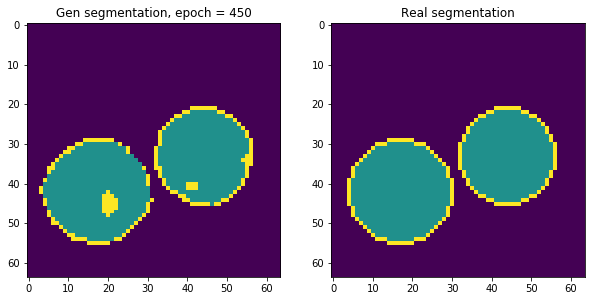

epoch - 450, loss - 1.06114637852
epoch - 451, loss - 1.06748640537
epoch - 452, loss - 1.06183028221
epoch - 453, loss - 1.06966662407
epoch - 454, loss - 1.06660044193
epoch - 455, loss - 1.08011436462
epoch - 456, loss - 1.06913840771
epoch - 457, loss - 1.09304106236
epoch - 458, loss - 1.06099998951
epoch - 459, loss - 1.0484650135
epoch - 460, loss - 1.01325547695
epoch - 461, loss - 0.996945381165
epoch - 462, loss - 0.988205432892
epoch - 463, loss - 1.01220142841
epoch - 464, loss - 1.03304743767
epoch - 465, loss - 1.00525617599
epoch - 466, loss - 1.05299723148
epoch - 467, loss - 0.986516952515
epoch - 468, loss - 0.98062723875
epoch - 469, loss - 0.963476538658
epoch - 470, loss - 0.945648133755
epoch - 471, loss - 0.959655344486
epoch - 472, loss - 0.946889519691
epoch - 473, loss - 0.949955642223
epoch - 474, loss - 0.95800024271
epoch - 475, loss - 0.962448120117
epoch - 476, loss - 0.954933106899
epoch - 477, loss - 0.955101847649
epoch - 478, loss - 0.912094116211
epo

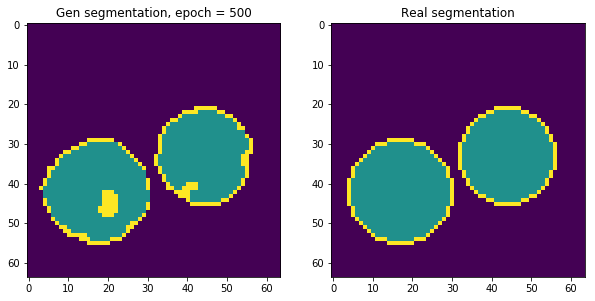

epoch - 500, loss - 0.805260956287
epoch - 501, loss - 0.839851081371
epoch - 502, loss - 0.823525726795
epoch - 503, loss - 0.823781728745
epoch - 504, loss - 0.781320989132
epoch - 505, loss - 0.796856403351
epoch - 506, loss - 0.749389052391
epoch - 507, loss - 0.766534388065
epoch - 508, loss - 0.738423883915
epoch - 509, loss - 0.753915727139
epoch - 510, loss - 0.728254318237
epoch - 511, loss - 0.736579120159
epoch - 512, loss - 0.718185305595
epoch - 513, loss - 0.718609035015
epoch - 514, loss - 0.711645126343
epoch - 515, loss - 0.704325199127
epoch - 516, loss - 0.702524185181
epoch - 517, loss - 0.696077406406
epoch - 518, loss - 0.70183712244
epoch - 519, loss - 0.699158787727
epoch - 520, loss - 0.721197903156
epoch - 521, loss - 0.74084764719
epoch - 522, loss - 0.804378032684
epoch - 523, loss - 0.791269421577
epoch - 524, loss - 0.791253566742
epoch - 525, loss - 0.700338125229
epoch - 526, loss - 0.655200779438
epoch - 527, loss - 0.662586092949
epoch - 528, loss - 0.

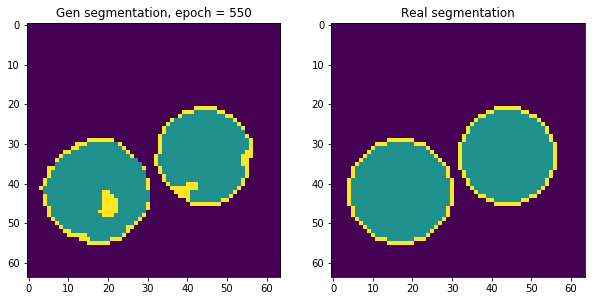

epoch - 550, loss - 0.562428176403
epoch - 551, loss - 0.549739480019
epoch - 552, loss - 0.541417181492
epoch - 553, loss - 0.534099876881
epoch - 554, loss - 0.532202124596
epoch - 555, loss - 0.525952756405
epoch - 556, loss - 0.529448032379
epoch - 557, loss - 0.535858154297
epoch - 558, loss - 0.542655646801
epoch - 559, loss - 0.57249045372
epoch - 560, loss - 0.583670437336
epoch - 561, loss - 0.610968887806
epoch - 562, loss - 0.576934695244
epoch - 563, loss - 0.553285181522
epoch - 564, loss - 0.508935809135
epoch - 565, loss - 0.502256393433
epoch - 566, loss - 0.51060551405
epoch - 567, loss - 0.531904757023
epoch - 568, loss - 0.537338912487
epoch - 569, loss - 0.510431945324
epoch - 570, loss - 0.484305888414
epoch - 571, loss - 0.471533417702
epoch - 572, loss - 0.480112344027
epoch - 573, loss - 0.491121739149
epoch - 574, loss - 0.495485395193
epoch - 575, loss - 0.486623257399
epoch - 576, loss - 0.466934204102
epoch - 577, loss - 0.454877853394
epoch - 578, loss - 0.

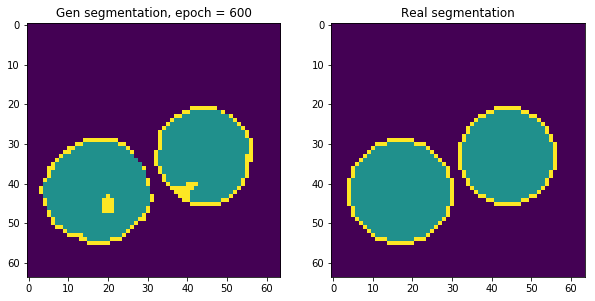

epoch - 600, loss - 0.390559017658
epoch - 601, loss - 0.391745090485
epoch - 602, loss - 0.39161837101
epoch - 603, loss - 0.411387532949
epoch - 604, loss - 0.40391010046
epoch - 605, loss - 0.396045744419
epoch - 606, loss - 0.408231914043
epoch - 607, loss - 0.376543372869
epoch - 608, loss - 0.369836062193
epoch - 609, loss - 0.354688882828
epoch - 610, loss - 0.364980071783
epoch - 611, loss - 0.358730018139
epoch - 612, loss - 0.376645326614
epoch - 613, loss - 0.38904234767
epoch - 614, loss - 0.394408851862
epoch - 615, loss - 0.393639862537
epoch - 616, loss - 0.384273767471
epoch - 617, loss - 0.384635448456
epoch - 618, loss - 0.351459294558
epoch - 619, loss - 0.346686065197
epoch - 620, loss - 0.337438136339
epoch - 621, loss - 0.349882990122
epoch - 622, loss - 0.350139826536
epoch - 623, loss - 0.371126323938
epoch - 624, loss - 0.370791584253
epoch - 625, loss - 0.356701612473
epoch - 626, loss - 0.341194242239
epoch - 627, loss - 0.339299470186
epoch - 628, loss - 0.3

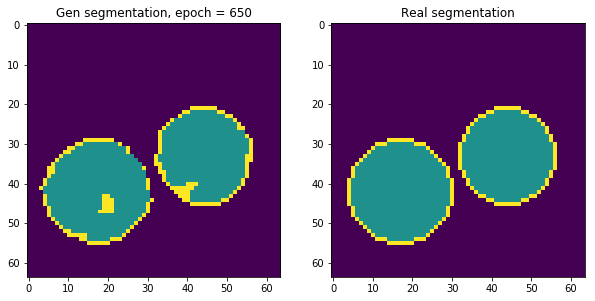

epoch - 650, loss - 0.271085619926
epoch - 651, loss - 0.25707051158
epoch - 652, loss - 0.259807497263
epoch - 653, loss - 0.263824909925
epoch - 654, loss - 0.262353509665
epoch - 655, loss - 0.262270510197
epoch - 656, loss - 0.269791722298
epoch - 657, loss - 0.277848035097
epoch - 658, loss - 0.276018619537
epoch - 659, loss - 0.282068103552
epoch - 660, loss - 0.2798576653
epoch - 661, loss - 0.284283995628
epoch - 662, loss - 0.269240856171
epoch - 663, loss - 0.262706160545
epoch - 664, loss - 0.244333803654
epoch - 665, loss - 0.233415871859
epoch - 666, loss - 0.229652523994
epoch - 667, loss - 0.233711332083
epoch - 668, loss - 0.236485674977
epoch - 669, loss - 0.240305423737
epoch - 670, loss - 0.244870126247
epoch - 671, loss - 0.245380550623
epoch - 672, loss - 0.243626400828
epoch - 673, loss - 0.23715120554
epoch - 674, loss - 0.233550384641
epoch - 675, loss - 0.224697679281
epoch - 676, loss - 0.218219190836
epoch - 677, loss - 0.211358740926
epoch - 678, loss - 0.20

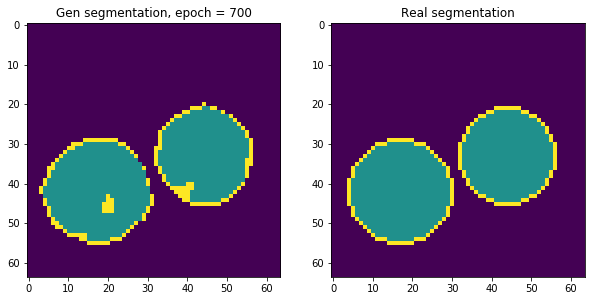

epoch - 700, loss - 0.18416595459
epoch - 701, loss - 0.193615585566
epoch - 702, loss - 0.20266969502
epoch - 703, loss - 0.203366756439
epoch - 704, loss - 0.189271882176
epoch - 705, loss - 0.178453415632
epoch - 706, loss - 0.168593257666
epoch - 707, loss - 0.174181252718
epoch - 708, loss - 0.17805556953
epoch - 709, loss - 0.185128077865
epoch - 710, loss - 0.184852734208
epoch - 711, loss - 0.178739950061
epoch - 712, loss - 0.171623706818
epoch - 713, loss - 0.162979289889
epoch - 714, loss - 0.16184040904
epoch - 715, loss - 0.158555522561
epoch - 716, loss - 0.163527160883
epoch - 717, loss - 0.164804294705
epoch - 718, loss - 0.16977623105
epoch - 719, loss - 0.173805236816
epoch - 720, loss - 0.174132496119
epoch - 721, loss - 0.178837805986
epoch - 722, loss - 0.172230273485
epoch - 723, loss - 0.174026578665
epoch - 724, loss - 0.166039764881
epoch - 725, loss - 0.167306095362
epoch - 726, loss - 0.157639637589
epoch - 727, loss - 0.15534697473
epoch - 728, loss - 0.1555

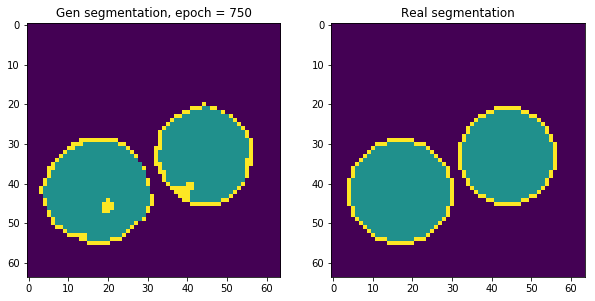

epoch - 750, loss - 0.134968712926
epoch - 751, loss - 0.14763431251
epoch - 752, loss - 0.172169938684
epoch - 753, loss - 0.232227236032
epoch - 754, loss - 0.258907437325
epoch - 755, loss - 0.32168713212
epoch - 756, loss - 0.236405670643
epoch - 757, loss - 0.168869718909
epoch - 758, loss - 0.121509104967
epoch - 759, loss - 0.152888402343
epoch - 760, loss - 0.215159952641
epoch - 761, loss - 0.179655909538
epoch - 762, loss - 0.13266633451
epoch - 763, loss - 0.117354542017
epoch - 764, loss - 0.147373452783
epoch - 765, loss - 0.175162449479
epoch - 766, loss - 0.143349409103
epoch - 767, loss - 0.113384023309
epoch - 768, loss - 0.117038413882
epoch - 769, loss - 0.13501739502
epoch - 770, loss - 0.145637363195
epoch - 771, loss - 0.121837645769
epoch - 772, loss - 0.10639616847
epoch - 773, loss - 0.112029843032
epoch - 774, loss - 0.123480655253
epoch - 775, loss - 0.124570421875
epoch - 776, loss - 0.10931456089
epoch - 777, loss - 0.101781703532
epoch - 778, loss - 0.1059

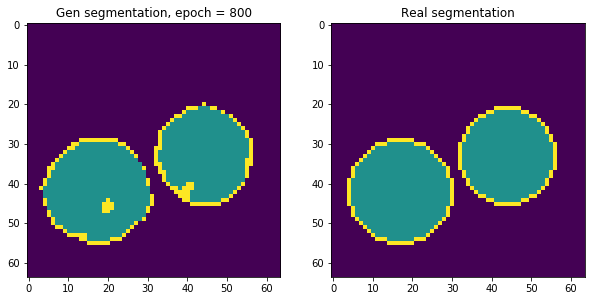

epoch - 800, loss - 0.0997447595
epoch - 801, loss - 0.10556960851
epoch - 802, loss - 0.10576724261
epoch - 803, loss - 0.109667673707
epoch - 804, loss - 0.102853029966
epoch - 805, loss - 0.0982737913728
epoch - 806, loss - 0.0890004485846
epoch - 807, loss - 0.082718834281
epoch - 808, loss - 0.0794327557087
epoch - 809, loss - 0.0799586102366
epoch - 810, loss - 0.0829588472843
epoch - 811, loss - 0.0852297097445
epoch - 812, loss - 0.0878250673413
epoch - 813, loss - 0.0859199762344
epoch - 814, loss - 0.0836699455976
epoch - 815, loss - 0.0797999948263
epoch - 816, loss - 0.0772617012262
epoch - 817, loss - 0.0765174254775
epoch - 818, loss - 0.0775091573596
epoch - 819, loss - 0.0778734907508
epoch - 820, loss - 0.0780637934804
epoch - 821, loss - 0.0772811695933
epoch - 822, loss - 0.0755953043699
epoch - 823, loss - 0.0730888098478
epoch - 824, loss - 0.0715852603316
epoch - 825, loss - 0.0708795115352
epoch - 826, loss - 0.0713709145784
epoch - 827, loss - 0.0724711418152
ep

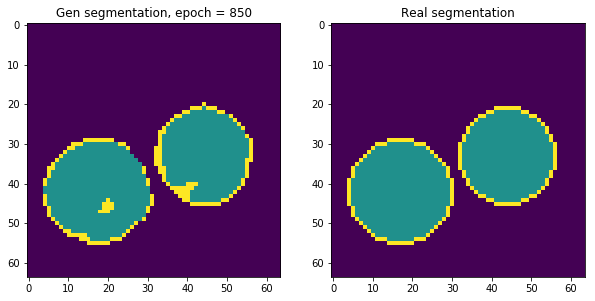

epoch - 850, loss - 0.0642139464617
epoch - 851, loss - 0.0668021142483
epoch - 852, loss - 0.0718024149537
epoch - 853, loss - 0.0762080848217
epoch - 854, loss - 0.0710802674294
epoch - 855, loss - 0.0646811053157
epoch - 856, loss - 0.0594494976103
epoch - 857, loss - 0.0595054402947
epoch - 858, loss - 0.0629540979862
epoch - 859, loss - 0.0655991360545
epoch - 860, loss - 0.0665215775371
epoch - 861, loss - 0.0628258138895
epoch - 862, loss - 0.0589107871056
epoch - 863, loss - 0.0559575557709
epoch - 864, loss - 0.0555530749261
epoch - 865, loss - 0.0569368675351
epoch - 866, loss - 0.0584737770259
epoch - 867, loss - 0.0593413673341
epoch - 868, loss - 0.0581891164184
epoch - 869, loss - 0.0566418208182
epoch - 870, loss - 0.0545367263258
epoch - 871, loss - 0.0532905682921
epoch - 872, loss - 0.052694760263
epoch - 873, loss - 0.0526014566422
epoch - 874, loss - 0.0526854656637
epoch - 875, loss - 0.0524842366576
epoch - 876, loss - 0.0518919229507
epoch - 877, loss - 0.0513250

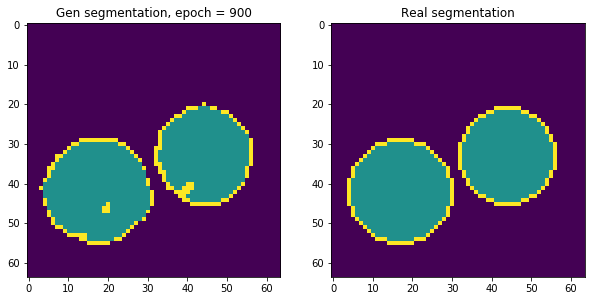

epoch - 900, loss - 0.0705844908953
epoch - 901, loss - 0.101166591048
epoch - 902, loss - 0.09285145998
epoch - 903, loss - 0.0758668705821
epoch - 904, loss - 0.0564454086125
epoch - 905, loss - 0.0611364468932
epoch - 906, loss - 0.0781740993261
epoch - 907, loss - 0.0736368075013
epoch - 908, loss - 0.060840729624
epoch - 909, loss - 0.0488511808217
epoch - 910, loss - 0.0517431646585
epoch - 911, loss - 0.062714330852
epoch - 912, loss - 0.0617491975427
epoch - 913, loss - 0.0554783195257
epoch - 914, loss - 0.0464314632118
epoch - 915, loss - 0.0458005741239
epoch - 916, loss - 0.0502076372504
epoch - 917, loss - 0.0514065660536
epoch - 918, loss - 0.0513030216098
epoch - 919, loss - 0.0476047955453
epoch - 920, loss - 0.0449179969728
epoch - 921, loss - 0.0426988825202
epoch - 922, loss - 0.042712457478
epoch - 923, loss - 0.0435400120914
epoch - 924, loss - 0.0440464802086
epoch - 925, loss - 0.0441780053079
epoch - 926, loss - 0.043386772275
epoch - 927, loss - 0.0427258983254

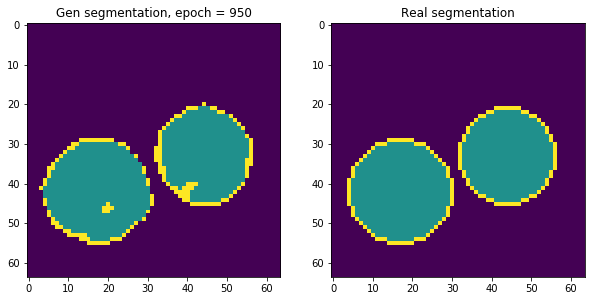

epoch - 950, loss - 0.036497592926
epoch - 951, loss - 0.0393072366714
epoch - 952, loss - 0.0427942350507
epoch - 953, loss - 0.0498804114759
epoch - 954, loss - 0.0553190968931
epoch - 955, loss - 0.0669606029987
epoch - 956, loss - 0.0707283988595
epoch - 957, loss - 0.0815524384379
epoch - 958, loss - 0.0753961503506
epoch - 959, loss - 0.0742043629289
epoch - 960, loss - 0.057994812727
epoch - 961, loss - 0.0482160151005
epoch - 962, loss - 0.041366841644
epoch - 963, loss - 0.0412576571107
epoch - 964, loss - 0.0442921072245
epoch - 965, loss - 0.0433065146208
epoch - 966, loss - 0.0418183803558
epoch - 967, loss - 0.038719303906
epoch - 968, loss - 0.0391878783703
epoch - 969, loss - 0.0407656133175
epoch - 970, loss - 0.0416683331132
epoch - 971, loss - 0.039030238986
epoch - 972, loss - 0.0337210930884
epoch - 973, loss - 0.0302406102419
epoch - 974, loss - 0.0304106771946
epoch - 975, loss - 0.0333878062665
epoch - 976, loss - 0.0357975438237
epoch - 977, loss - 0.03589014336

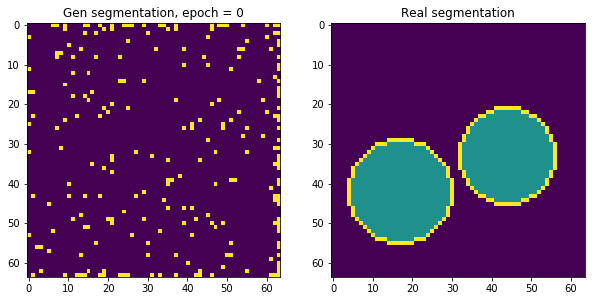

epoch - 0, loss - 6.50649547577
epoch - 1, loss - 12.8767766953
epoch - 2, loss - 6.86690807343
epoch - 3, loss - 6.33397054672
epoch - 4, loss - 6.51295042038
epoch - 5, loss - 6.44447851181
epoch - 6, loss - 6.34188938141
epoch - 7, loss - 6.29381418228
epoch - 8, loss - 6.27203941345
epoch - 9, loss - 6.24850034714
epoch - 10, loss - 6.22007274628
epoch - 11, loss - 6.18343639374
epoch - 12, loss - 6.1331744194
epoch - 13, loss - 6.07335472107
epoch - 14, loss - 6.02992105484
epoch - 15, loss - 6.0169301033
epoch - 16, loss - 6.0423374176
epoch - 17, loss - 5.98801279068
epoch - 18, loss - 5.96345758438
epoch - 19, loss - 5.92570257187
epoch - 20, loss - 5.92120265961
epoch - 21, loss - 5.90965938568
epoch - 22, loss - 5.89068126678
epoch - 23, loss - 5.8783659935
epoch - 24, loss - 5.86494016647
epoch - 25, loss - 5.84706068039
epoch - 26, loss - 5.82995223999
epoch - 27, loss - 5.81116867065
epoch - 28, loss - 5.7929315567
epoch - 29, loss - 5.81468153
epoch - 30, loss - 5.8358139

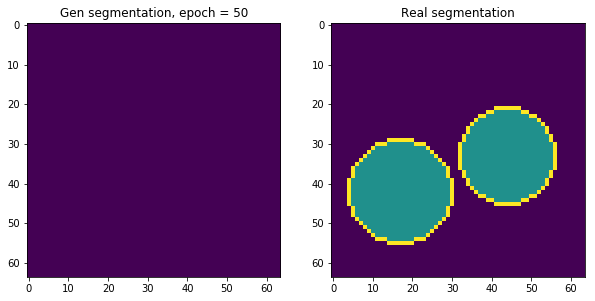

epoch - 50, loss - 5.69989204407
epoch - 51, loss - 5.77283096313
epoch - 52, loss - 5.77332115173
epoch - 53, loss - 5.68614149094
epoch - 54, loss - 5.71368408203
epoch - 55, loss - 5.67614650726
epoch - 56, loss - 5.64745616913
epoch - 57, loss - 5.68253707886
epoch - 58, loss - 5.65316486359
epoch - 59, loss - 5.62938022614
epoch - 60, loss - 5.65649843216
epoch - 61, loss - 5.61526823044
epoch - 62, loss - 5.61800813675
epoch - 63, loss - 5.61595726013
epoch - 64, loss - 5.58528423309
epoch - 65, loss - 5.58083677292
epoch - 66, loss - 5.55445718765
epoch - 67, loss - 5.55894422531
epoch - 68, loss - 5.52162837982
epoch - 69, loss - 5.53569412231
epoch - 70, loss - 5.50075244904
epoch - 71, loss - 5.46048355103
epoch - 72, loss - 5.4828338623
epoch - 73, loss - 5.53509140015
epoch - 74, loss - 5.50230503082
epoch - 75, loss - 5.38031864166
epoch - 76, loss - 5.37327480316
epoch - 77, loss - 5.43651771545
epoch - 78, loss - 5.43758153915
epoch - 79, loss - 5.34583616257
epoch - 80,

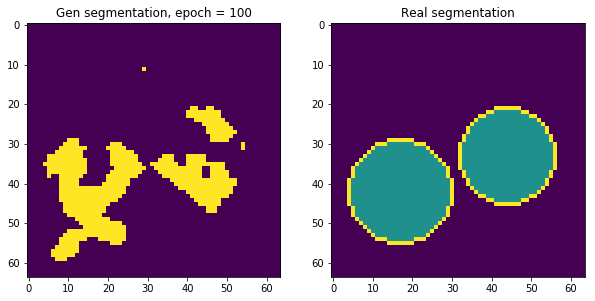

epoch - 100, loss - 4.14868307114
epoch - 101, loss - 4.19143915176
epoch - 102, loss - 4.20099115372
epoch - 103, loss - 4.02115917206
epoch - 104, loss - 4.07407236099
epoch - 105, loss - 3.97059965134
epoch - 106, loss - 3.93043923378
epoch - 107, loss - 3.91691160202
epoch - 108, loss - 3.81100702286
epoch - 109, loss - 3.81294775009
epoch - 110, loss - 3.72098994255
epoch - 111, loss - 3.7211432457
epoch - 112, loss - 3.6820025444
epoch - 113, loss - 3.65945005417
epoch - 114, loss - 3.63651061058
epoch - 115, loss - 3.58354711533
epoch - 116, loss - 3.5743534565
epoch - 117, loss - 3.53797650337
epoch - 118, loss - 3.53518843651
epoch - 119, loss - 3.4964299202
epoch - 120, loss - 3.47991728783
epoch - 121, loss - 3.4534907341
epoch - 122, loss - 3.44139075279
epoch - 123, loss - 3.42307257652
epoch - 124, loss - 3.4004907608
epoch - 125, loss - 3.38939070702
epoch - 126, loss - 3.36984276772
epoch - 127, loss - 3.36154961586
epoch - 128, loss - 3.33970236778
epoch - 129, loss - 

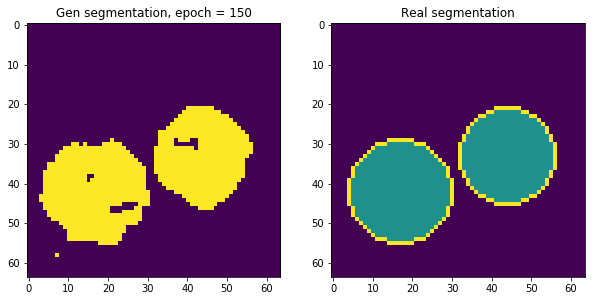

epoch - 150, loss - 3.11068606377
epoch - 151, loss - 3.10216617584
epoch - 152, loss - 3.09273314476
epoch - 153, loss - 3.08397650719
epoch - 154, loss - 3.07580566406
epoch - 155, loss - 3.06825733185
epoch - 156, loss - 3.06489634514
epoch - 157, loss - 3.07115292549
epoch - 158, loss - 3.10101389885
epoch - 159, loss - 3.18913841248
epoch - 160, loss - 3.22708058357
epoch - 161, loss - 3.19408941269
epoch - 162, loss - 3.02776241302
epoch - 163, loss - 3.10774087906
epoch - 164, loss - 3.17641878128
epoch - 165, loss - 3.0019402504
epoch - 166, loss - 3.13746738434
epoch - 167, loss - 3.12732458115
epoch - 168, loss - 3.01258397102
epoch - 169, loss - 3.15364694595
epoch - 170, loss - 3.02669978142
epoch - 171, loss - 3.05632662773
epoch - 172, loss - 3.00398612022
epoch - 173, loss - 3.00173139572
epoch - 174, loss - 2.99302458763
epoch - 175, loss - 2.99594593048
epoch - 176, loss - 2.96426296234
epoch - 177, loss - 2.97346568108
epoch - 178, loss - 2.93544650078
epoch - 179, lo

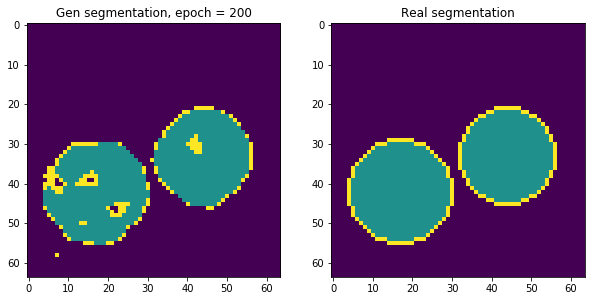

epoch - 200, loss - 2.76750826836
epoch - 201, loss - 2.76374340057
epoch - 202, loss - 2.76480150223
epoch - 203, loss - 2.77250170708
epoch - 204, loss - 2.80223631859
epoch - 205, loss - 2.82925438881
epoch - 206, loss - 2.86393260956
epoch - 207, loss - 2.83452010155
epoch - 208, loss - 2.75891041756
epoch - 209, loss - 2.70894384384
epoch - 210, loss - 2.70823311806
epoch - 211, loss - 2.74502849579
epoch - 212, loss - 2.73616051674
epoch - 213, loss - 2.69999718666
epoch - 214, loss - 2.67789912224
epoch - 215, loss - 2.68397212029
epoch - 216, loss - 2.69579172134
epoch - 217, loss - 2.67933797836
epoch - 218, loss - 2.65834522247
epoch - 219, loss - 2.64579749107
epoch - 220, loss - 2.65442538261
epoch - 221, loss - 2.66427135468
epoch - 222, loss - 2.66527962685
epoch - 223, loss - 2.64108037949
epoch - 224, loss - 2.61464691162
epoch - 225, loss - 2.60461616516
epoch - 226, loss - 2.61475157738
epoch - 227, loss - 2.62018704414
epoch - 228, loss - 2.61275434494
epoch - 229, l

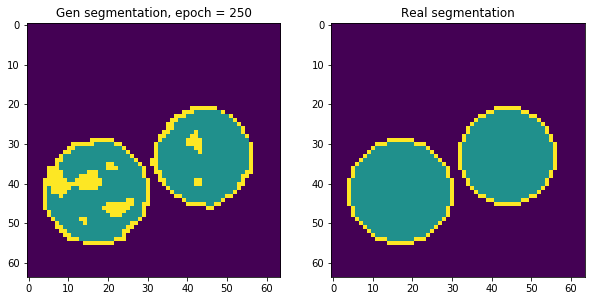

epoch - 250, loss - 2.52627491951
epoch - 251, loss - 2.57676768303
epoch - 252, loss - 2.51803708076
epoch - 253, loss - 2.53291082382
epoch - 254, loss - 2.52745199203
epoch - 255, loss - 2.50461816788
epoch - 256, loss - 2.50424075127
epoch - 257, loss - 2.50576353073
epoch - 258, loss - 2.48273253441
epoch - 259, loss - 2.48977279663
epoch - 260, loss - 2.4728474617
epoch - 261, loss - 2.48303437233
epoch - 262, loss - 2.46672272682
epoch - 263, loss - 2.45456314087
epoch - 264, loss - 2.45227789879
epoch - 265, loss - 2.45201230049
epoch - 266, loss - 2.4470949173
epoch - 267, loss - 2.4401614666
epoch - 268, loss - 2.42666530609
epoch - 269, loss - 2.42538928986
epoch - 270, loss - 2.41710400581
epoch - 271, loss - 2.41908073425
epoch - 272, loss - 2.41669845581
epoch - 273, loss - 2.41474270821
epoch - 274, loss - 2.4151237011
epoch - 275, loss - 2.40858435631
epoch - 276, loss - 2.40766406059
epoch - 277, loss - 2.40211701393
epoch - 278, loss - 2.39941072464
epoch - 279, loss 

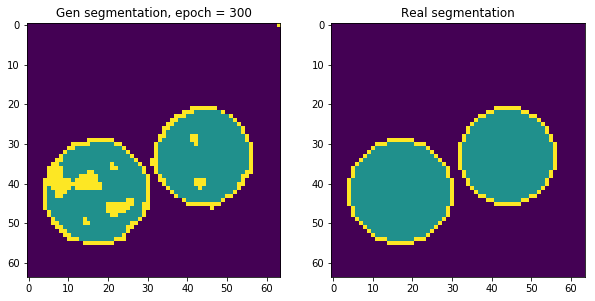

epoch - 300, loss - 2.36288499832
epoch - 301, loss - 2.33593130112
epoch - 302, loss - 2.29114198685
epoch - 303, loss - 2.31969738007
epoch - 304, loss - 2.32896256447
epoch - 305, loss - 2.28830504417
epoch - 306, loss - 2.27676010132
epoch - 307, loss - 2.30016255379
epoch - 308, loss - 2.29873728752
epoch - 309, loss - 2.28217029572
epoch - 310, loss - 2.25915336609
epoch - 311, loss - 2.25497794151
epoch - 312, loss - 2.26904201508
epoch - 313, loss - 2.28002333641
epoch - 314, loss - 2.27002668381
epoch - 315, loss - 2.25209403038
epoch - 316, loss - 2.24008774757
epoch - 317, loss - 2.22557520866
epoch - 318, loss - 2.22677302361
epoch - 319, loss - 2.23456811905
epoch - 320, loss - 2.24285364151
epoch - 321, loss - 2.24444890022
epoch - 322, loss - 2.25100421906
epoch - 323, loss - 2.25146865845
epoch - 324, loss - 2.23913455009
epoch - 325, loss - 2.22338557243
epoch - 326, loss - 2.20609855652
epoch - 327, loss - 2.19355559349
epoch - 328, loss - 2.18287301064
epoch - 329, l

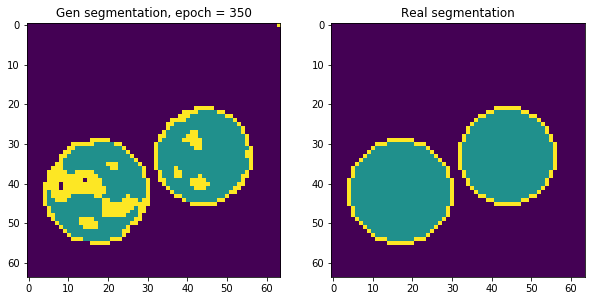

epoch - 350, loss - 2.13059830666
epoch - 351, loss - 2.15393090248
epoch - 352, loss - 2.22471761703
epoch - 353, loss - 2.29372477531
epoch - 354, loss - 2.24993419647
epoch - 355, loss - 2.15950107574
epoch - 356, loss - 2.12010669708
epoch - 357, loss - 2.14061307907
epoch - 358, loss - 2.12035679817
epoch - 359, loss - 2.11242842674
epoch - 360, loss - 2.1283082962
epoch - 361, loss - 2.09916806221
epoch - 362, loss - 2.06085133553
epoch - 363, loss - 2.07965564728
epoch - 364, loss - 2.09358477592
epoch - 365, loss - 2.05797553062
epoch - 366, loss - 2.04023623466
epoch - 367, loss - 2.06248688698
epoch - 368, loss - 2.05539083481
epoch - 369, loss - 2.0275747776
epoch - 370, loss - 2.02950286865
epoch - 371, loss - 2.04138445854
epoch - 372, loss - 2.02529096603
epoch - 373, loss - 2.01273560524
epoch - 374, loss - 2.03216791153
epoch - 375, loss - 2.08003664017
epoch - 376, loss - 2.14917349815
epoch - 377, loss - 2.19495868683
epoch - 378, loss - 2.13418936729
epoch - 379, los

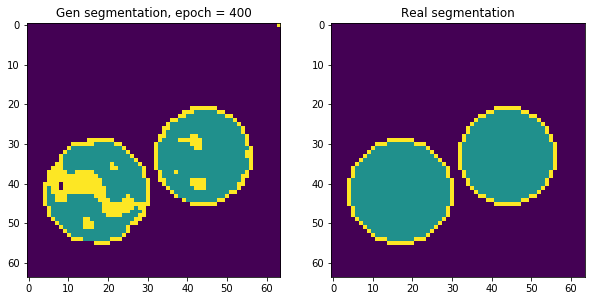

epoch - 400, loss - 1.92725431919
epoch - 401, loss - 1.91570448875
epoch - 402, loss - 1.91377437115
epoch - 403, loss - 1.92494523525
epoch - 404, loss - 1.95139837265
epoch - 405, loss - 1.98621678352
epoch - 406, loss - 2.00419425964
epoch - 407, loss - 2.00491666794
epoch - 408, loss - 1.97508215904
epoch - 409, loss - 1.91475236416
epoch - 410, loss - 1.87533676624
epoch - 411, loss - 1.88148367405
epoch - 412, loss - 1.91215443611
epoch - 413, loss - 1.9205493927
epoch - 414, loss - 1.88072729111
epoch - 415, loss - 1.84949171543
epoch - 416, loss - 1.85457110405
epoch - 417, loss - 1.87071669102
epoch - 418, loss - 1.87477099895
epoch - 419, loss - 1.87031555176
epoch - 420, loss - 1.87955987453
epoch - 421, loss - 1.88447475433
epoch - 422, loss - 1.86990177631
epoch - 423, loss - 1.84531104565
epoch - 424, loss - 1.83377718925
epoch - 425, loss - 1.82943665981
epoch - 426, loss - 1.81801056862
epoch - 427, loss - 1.80167019367
epoch - 428, loss - 1.79367399216
epoch - 429, lo

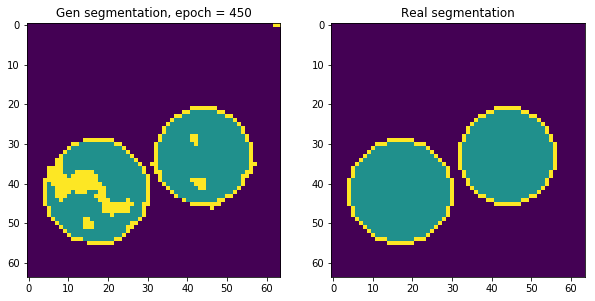

epoch - 450, loss - 1.75824725628
epoch - 451, loss - 1.75163924694
epoch - 452, loss - 1.75320744514
epoch - 453, loss - 1.78261089325
epoch - 454, loss - 1.77887070179
epoch - 455, loss - 1.77294504642
epoch - 456, loss - 1.75709605217
epoch - 457, loss - 1.72128820419
epoch - 458, loss - 1.69429409504
epoch - 459, loss - 1.68585312366
epoch - 460, loss - 1.68279588223
epoch - 461, loss - 1.69317674637
epoch - 462, loss - 1.705514431
epoch - 463, loss - 1.69524538517
epoch - 464, loss - 1.67823660374
epoch - 465, loss - 1.66655361652
epoch - 466, loss - 1.65658068657
epoch - 467, loss - 1.64289629459
epoch - 468, loss - 1.64073646069
epoch - 469, loss - 1.64923417568
epoch - 470, loss - 1.65914368629
epoch - 471, loss - 1.67829692364
epoch - 472, loss - 1.72026705742
epoch - 473, loss - 1.76809668541
epoch - 474, loss - 1.74601221085
epoch - 475, loss - 1.68102359772
epoch - 476, loss - 1.63359332085
epoch - 477, loss - 1.61099207401
epoch - 478, loss - 1.61898171902
epoch - 479, los

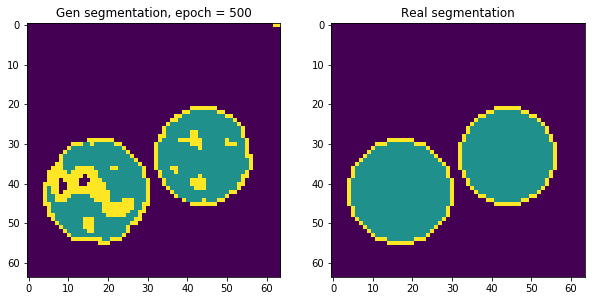

epoch - 500, loss - 1.52648866177
epoch - 501, loss - 1.51270759106
epoch - 502, loss - 1.51137089729
epoch - 503, loss - 1.52062237263
epoch - 504, loss - 1.5298422575
epoch - 505, loss - 1.53326678276
epoch - 506, loss - 1.51239943504
epoch - 507, loss - 1.49223518372
epoch - 508, loss - 1.48599016666
epoch - 509, loss - 1.51012396812
epoch - 510, loss - 1.57572305202
epoch - 511, loss - 1.64812016487
epoch - 512, loss - 1.64242577553
epoch - 513, loss - 1.59754419327
epoch - 514, loss - 1.58098006248
epoch - 515, loss - 1.57046639919
epoch - 516, loss - 1.49659717083
epoch - 517, loss - 1.46683943272
epoch - 518, loss - 1.50806748867
epoch - 519, loss - 1.52144312859
epoch - 520, loss - 1.45643997192
epoch - 521, loss - 1.43785452843
epoch - 522, loss - 1.47568821907
epoch - 523, loss - 1.46857893467
epoch - 524, loss - 1.42593050003
epoch - 525, loss - 1.4350297451
epoch - 526, loss - 1.46137523651
epoch - 527, loss - 1.44296550751
epoch - 528, loss - 1.44410502911
epoch - 529, los

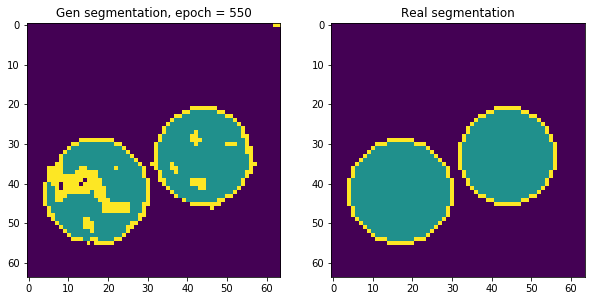

epoch - 550, loss - 1.35609567165
epoch - 551, loss - 1.3979088068
epoch - 552, loss - 1.42149877548
epoch - 553, loss - 1.41081833839
epoch - 554, loss - 1.38742983341
epoch - 555, loss - 1.35723984241
epoch - 556, loss - 1.32912957668
epoch - 557, loss - 1.31656479836
epoch - 558, loss - 1.32488894463
epoch - 559, loss - 1.33751761913
epoch - 560, loss - 1.33686995506
epoch - 561, loss - 1.32990455627
epoch - 562, loss - 1.32010710239
epoch - 563, loss - 1.29086899757
epoch - 564, loss - 1.26803731918
epoch - 565, loss - 1.27452433109
epoch - 566, loss - 1.29373812675
epoch - 567, loss - 1.29245483875
epoch - 568, loss - 1.27338671684
epoch - 569, loss - 1.26323747635
epoch - 570, loss - 1.27004635334
epoch - 571, loss - 1.28329408169
epoch - 572, loss - 1.28589558601
epoch - 573, loss - 1.25820064545
epoch - 574, loss - 1.25410687923
epoch - 575, loss - 1.27144896984
epoch - 576, loss - 1.28796994686
epoch - 577, loss - 1.29307496548
epoch - 578, loss - 1.28813588619
epoch - 579, lo

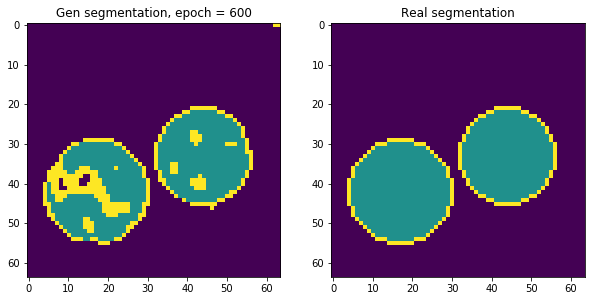

epoch - 600, loss - 1.14548873901
epoch - 601, loss - 1.13275587559
epoch - 602, loss - 1.142791152
epoch - 603, loss - 1.15072000027
epoch - 604, loss - 1.16286683083
epoch - 605, loss - 1.19280004501
epoch - 606, loss - 1.23910701275
epoch - 607, loss - 1.26028370857
epoch - 608, loss - 1.21361327171
epoch - 609, loss - 1.16422379017
epoch - 610, loss - 1.13970255852
epoch - 611, loss - 1.13031256199
epoch - 612, loss - 1.13334274292
epoch - 613, loss - 1.14747524261
epoch - 614, loss - 1.15573620796
epoch - 615, loss - 1.13719522953
epoch - 616, loss - 1.09698450565
epoch - 617, loss - 1.08325791359
epoch - 618, loss - 1.10378611088
epoch - 619, loss - 1.11348724365
epoch - 620, loss - 1.10231995583
epoch - 621, loss - 1.10637366772
epoch - 622, loss - 1.13301575184
epoch - 623, loss - 1.14554798603
epoch - 624, loss - 1.11964309216
epoch - 625, loss - 1.09998488426
epoch - 626, loss - 1.09519696236
epoch - 627, loss - 1.07368373871
epoch - 628, loss - 1.0459843874
epoch - 629, loss

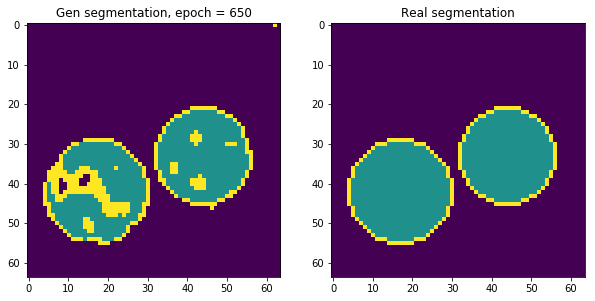

epoch - 650, loss - 1.0010612011
epoch - 651, loss - 0.975543558598
epoch - 652, loss - 0.976215422153
epoch - 653, loss - 0.993406176567
epoch - 654, loss - 1.01073253155
epoch - 655, loss - 1.03216445446
epoch - 656, loss - 1.06160712242
epoch - 657, loss - 1.10172104836
epoch - 658, loss - 1.1119171381
epoch - 659, loss - 1.06064414978
epoch - 660, loss - 0.983096241951
epoch - 661, loss - 0.950634121895
epoch - 662, loss - 0.977424144745
epoch - 663, loss - 1.01920926571
epoch - 664, loss - 1.01162791252
epoch - 665, loss - 0.95874363184
epoch - 666, loss - 0.928632616997
epoch - 667, loss - 0.945660471916
epoch - 668, loss - 0.97650462389
epoch - 669, loss - 0.97839641571
epoch - 670, loss - 0.942587018013
epoch - 671, loss - 0.920653820038
epoch - 672, loss - 0.931345820427
epoch - 673, loss - 0.936993360519
epoch - 674, loss - 0.923311769962
epoch - 675, loss - 0.901210188866
epoch - 676, loss - 0.90941375494
epoch - 677, loss - 0.937638700008
epoch - 678, loss - 0.931300699711


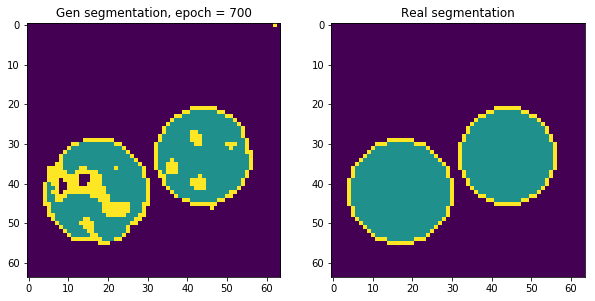

epoch - 700, loss - 0.842048704624
epoch - 701, loss - 0.835120201111
epoch - 702, loss - 0.825207650661
epoch - 703, loss - 0.819481194019
epoch - 704, loss - 0.822939276695
epoch - 705, loss - 0.831076681614
epoch - 706, loss - 0.840789079666
epoch - 707, loss - 0.850558340549
epoch - 708, loss - 0.876487314701
epoch - 709, loss - 0.925403475761
epoch - 710, loss - 0.961068868637
epoch - 711, loss - 0.933632254601
epoch - 712, loss - 0.848930120468
epoch - 713, loss - 0.81114178896
epoch - 714, loss - 0.821187257767
epoch - 715, loss - 0.83771699667
epoch - 716, loss - 0.837588429451
epoch - 717, loss - 0.817690253258
epoch - 718, loss - 0.80610960722
epoch - 719, loss - 0.807636022568
epoch - 720, loss - 0.810976862907
epoch - 721, loss - 0.803318083286
epoch - 722, loss - 0.78993076086
epoch - 723, loss - 0.774710714817
epoch - 724, loss - 0.774596810341
epoch - 725, loss - 0.786851346493
epoch - 726, loss - 0.795066535473
epoch - 727, loss - 0.785487771034
epoch - 728, loss - 0.76

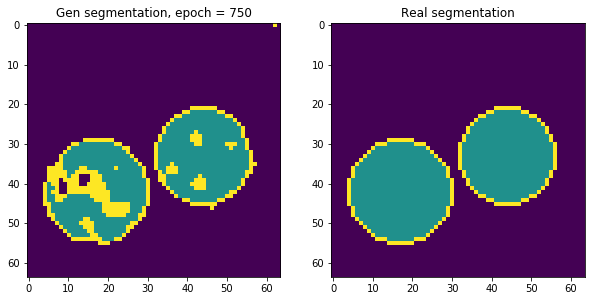

epoch - 750, loss - 0.740241587162
epoch - 751, loss - 0.728220522404
epoch - 752, loss - 0.738241314888
epoch - 753, loss - 0.791465163231
epoch - 754, loss - 0.815413594246
epoch - 755, loss - 0.784950077534
epoch - 756, loss - 0.749779701233
epoch - 757, loss - 0.734176397324
epoch - 758, loss - 0.708909928799
epoch - 759, loss - 0.694465339184
epoch - 760, loss - 0.70238751173
epoch - 761, loss - 0.709529101849
epoch - 762, loss - 0.697503328323
epoch - 763, loss - 0.692055225372
epoch - 764, loss - 0.703327894211
epoch - 765, loss - 0.706594586372
epoch - 766, loss - 0.683262705803
epoch - 767, loss - 0.671889483929
epoch - 768, loss - 0.673975944519
epoch - 769, loss - 0.677451908588
epoch - 770, loss - 0.679215610027
epoch - 771, loss - 0.674924552441
epoch - 772, loss - 0.674504041672
epoch - 773, loss - 0.669353067875
epoch - 774, loss - 0.667572081089
epoch - 775, loss - 0.685235202312
epoch - 776, loss - 0.733501195908
epoch - 777, loss - 0.787015318871
epoch - 778, loss - 0

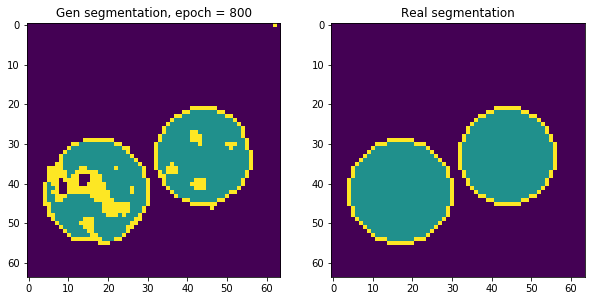

epoch - 800, loss - 0.591640591621
epoch - 801, loss - 0.591022312641
epoch - 802, loss - 0.596461594105
epoch - 803, loss - 0.599766254425
epoch - 804, loss - 0.598042905331
epoch - 805, loss - 0.59240680933
epoch - 806, loss - 0.586477458477
epoch - 807, loss - 0.581431150436
epoch - 808, loss - 0.5841319561
epoch - 809, loss - 0.60090136528
epoch - 810, loss - 0.624986946583
epoch - 811, loss - 0.638536155224
epoch - 812, loss - 0.641459822655
epoch - 813, loss - 0.652813017368
epoch - 814, loss - 0.665937066078
epoch - 815, loss - 0.656433522701
epoch - 816, loss - 0.609101593494
epoch - 817, loss - 0.565948665142
epoch - 818, loss - 0.562114655972
epoch - 819, loss - 0.587643325329
epoch - 820, loss - 0.600802183151
epoch - 821, loss - 0.578855514526
epoch - 822, loss - 0.554573893547
epoch - 823, loss - 0.558725893497
epoch - 824, loss - 0.585114240646
epoch - 825, loss - 0.579644739628
epoch - 826, loss - 0.556612610817
epoch - 827, loss - 0.539985656738
epoch - 828, loss - 0.55

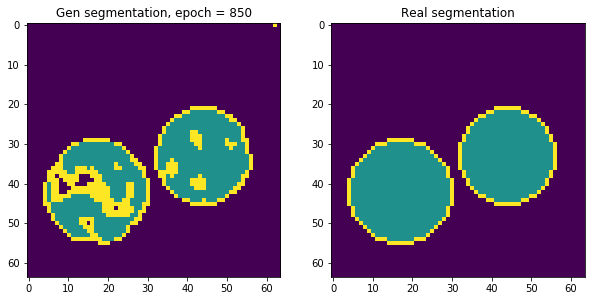

epoch - 850, loss - 0.533791422844
epoch - 851, loss - 0.518994092941
epoch - 852, loss - 0.498557537794
epoch - 853, loss - 0.497603774071
epoch - 854, loss - 0.512462496758
epoch - 855, loss - 0.520725131035
epoch - 856, loss - 0.527470946312
epoch - 857, loss - 0.549442768097
epoch - 858, loss - 0.590608656406
epoch - 859, loss - 0.605231642723
epoch - 860, loss - 0.563348770142
epoch - 861, loss - 0.527417421341
epoch - 862, loss - 0.517519652843
epoch - 863, loss - 0.513476371765
epoch - 864, loss - 0.51612919569
epoch - 865, loss - 0.52767932415
epoch - 866, loss - 0.54761081934
epoch - 867, loss - 0.536686062813
epoch - 868, loss - 0.500277280807
epoch - 869, loss - 0.480149894953
epoch - 870, loss - 0.484127134085
epoch - 871, loss - 0.489639312029
epoch - 872, loss - 0.483127832413
epoch - 873, loss - 0.480052500963
epoch - 874, loss - 0.496770232916
epoch - 875, loss - 0.501323461533
epoch - 876, loss - 0.481623768806
epoch - 877, loss - 0.47496214509
epoch - 878, loss - 0.49

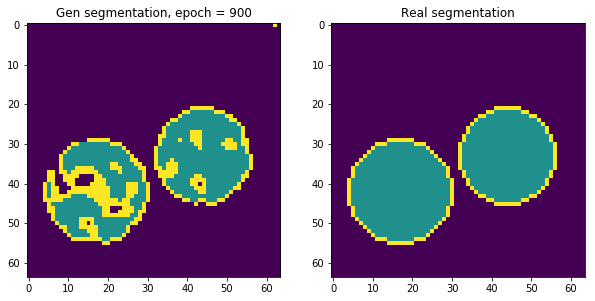

epoch - 900, loss - 0.607836902142
epoch - 901, loss - 0.618015170097
epoch - 902, loss - 0.534014046192
epoch - 903, loss - 0.447246938944
epoch - 904, loss - 0.444664359093
epoch - 905, loss - 0.487431794405
epoch - 906, loss - 0.506021261215
epoch - 907, loss - 0.487350344658
epoch - 908, loss - 0.466121524572
epoch - 909, loss - 0.451340913773
epoch - 910, loss - 0.449865102768
epoch - 911, loss - 0.460197478533
epoch - 912, loss - 0.464466392994
epoch - 913, loss - 0.444265395403
epoch - 914, loss - 0.417780786753
epoch - 915, loss - 0.426431208849
epoch - 916, loss - 0.450766205788
epoch - 917, loss - 0.447483032942
epoch - 918, loss - 0.413496732712
epoch - 919, loss - 0.397174686193
epoch - 920, loss - 0.414844483137
epoch - 921, loss - 0.432361483574
epoch - 922, loss - 0.425218433142
epoch - 923, loss - 0.407214283943
epoch - 924, loss - 0.412967294455
epoch - 925, loss - 0.435887932777
epoch - 926, loss - 0.44437405467
epoch - 927, loss - 0.416305601597
epoch - 928, loss - 0

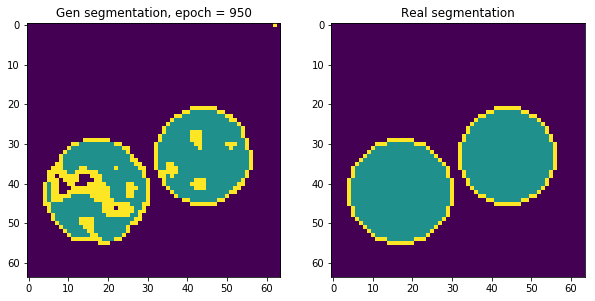

epoch - 950, loss - 0.374713927507
epoch - 951, loss - 0.38199570775
epoch - 952, loss - 0.386507809162
epoch - 953, loss - 0.38796839118
epoch - 954, loss - 0.389883518219
epoch - 955, loss - 0.392122983932
epoch - 956, loss - 0.388633131981
epoch - 957, loss - 0.376583307981
epoch - 958, loss - 0.363765180111
epoch - 959, loss - 0.353770643473
epoch - 960, loss - 0.346983164549
epoch - 961, loss - 0.345127522945
epoch - 962, loss - 0.345416516066
epoch - 963, loss - 0.351765275002
epoch - 964, loss - 0.358636707067
epoch - 965, loss - 0.366662234068
epoch - 966, loss - 0.372909784317
epoch - 967, loss - 0.381827265024
epoch - 968, loss - 0.394329488277
epoch - 969, loss - 0.401949286461
epoch - 970, loss - 0.399045944214
epoch - 971, loss - 0.381553769112
epoch - 972, loss - 0.356108993292
epoch - 973, loss - 0.335336118937
epoch - 974, loss - 0.332845121622
epoch - 975, loss - 0.341713070869
epoch - 976, loss - 0.351924866438
epoch - 977, loss - 0.35161921382
epoch - 978, loss - 0.3

In [34]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Network)

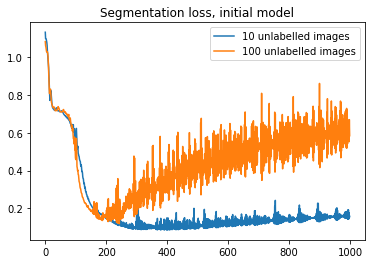

In [35]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, initial model')
plt.legend()
plt.show()

### Unet

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:961: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


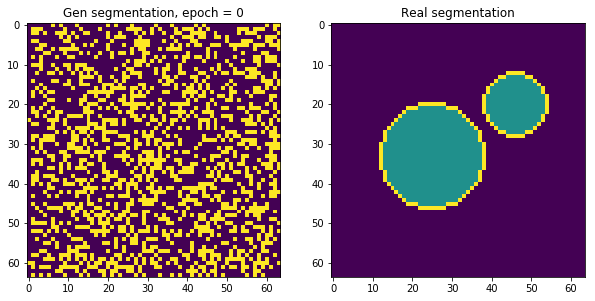

epoch - 0, loss - 96.7895431519
epoch - 1, loss - 82.1163482666
epoch - 2, loss - 69.1275100708
epoch - 3, loss - 58.1917533875
epoch - 4, loss - 49.060382843
epoch - 5, loss - 41.7242050171
epoch - 6, loss - 36.0535354614
epoch - 7, loss - 31.8383140564
epoch - 8, loss - 28.8162746429
epoch - 9, loss - 26.7131214142
epoch - 10, loss - 25.2288703918
epoch - 11, loss - 24.0812511444
epoch - 12, loss - 23.0911655426
epoch - 13, loss - 22.0900840759
epoch - 14, loss - 20.9945354462
epoch - 15, loss - 19.8318500519
epoch - 16, loss - 18.6229038239
epoch - 17, loss - 17.407283783
epoch - 18, loss - 16.2367191315
epoch - 19, loss - 15.144241333
epoch - 20, loss - 14.161110878
epoch - 21, loss - 13.3166723251
epoch - 22, loss - 12.6045532227
epoch - 23, loss - 12.0047235489
epoch - 24, loss - 11.4946594238
epoch - 25, loss - 11.0515527725
epoch - 26, loss - 10.6487407684
epoch - 27, loss - 10.265253067
epoch - 28, loss - 9.902302742
epoch - 29, loss - 9.55802249908
epoch - 30, loss - 9.235190

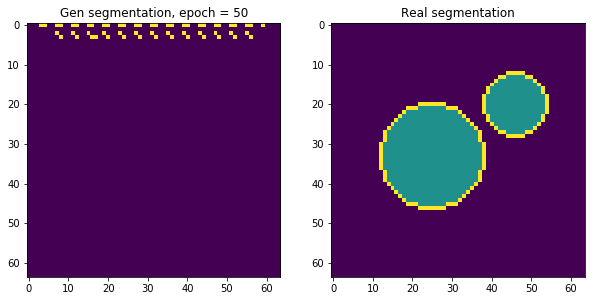

epoch - 50, loss - 6.02923822403
epoch - 51, loss - 5.9789147377
epoch - 52, loss - 5.9339838028
epoch - 53, loss - 5.89321708679
epoch - 54, loss - 5.85536003113
epoch - 55, loss - 5.81986570358
epoch - 56, loss - 5.78598070145
epoch - 57, loss - 5.75371217728
epoch - 58, loss - 5.7233915329
epoch - 59, loss - 5.69546127319
epoch - 60, loss - 5.66999053955
epoch - 61, loss - 5.64671134949
epoch - 62, loss - 5.62551784515
epoch - 63, loss - 5.60588550568
epoch - 64, loss - 5.58769273758
epoch - 65, loss - 5.57061386108
epoch - 66, loss - 5.5544257164
epoch - 67, loss - 5.5391497612
epoch - 68, loss - 5.5244884491
epoch - 69, loss - 5.51005125046
epoch - 70, loss - 5.49595880508
epoch - 71, loss - 5.48241329193
epoch - 72, loss - 5.4696521759
epoch - 73, loss - 5.45778894424
epoch - 74, loss - 5.44681882858
epoch - 75, loss - 5.43644762039
epoch - 76, loss - 5.42649126053
epoch - 77, loss - 5.41696166992
epoch - 78, loss - 5.40781879425
epoch - 79, loss - 5.39897632599
epoch - 80, loss 

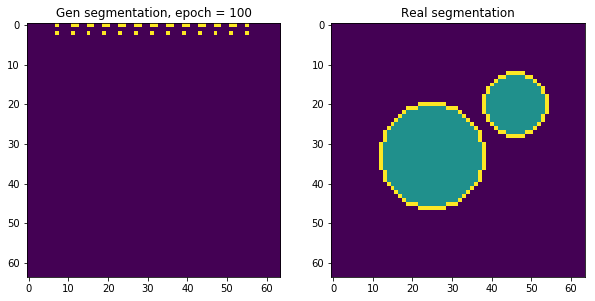

epoch - 100, loss - 5.26121330261
epoch - 101, loss - 5.25607061386
epoch - 102, loss - 5.25096273422
epoch - 103, loss - 5.24593067169
epoch - 104, loss - 5.24099636078
epoch - 105, loss - 5.23610877991
epoch - 106, loss - 5.23125600815
epoch - 107, loss - 5.22647285461
epoch - 108, loss - 5.22162055969
epoch - 109, loss - 5.21707391739
epoch - 110, loss - 5.21258211136
epoch - 111, loss - 5.20821905136
epoch - 112, loss - 5.2032790184
epoch - 113, loss - 5.19844341278
epoch - 114, loss - 5.19555807114
epoch - 115, loss - 5.1916885376
epoch - 116, loss - 5.18635559082
epoch - 117, loss - 5.18506860733
epoch - 118, loss - 5.17693519592
epoch - 119, loss - 5.1741104126
epoch - 120, loss - 5.16836738586
epoch - 121, loss - 5.16613578796
epoch - 122, loss - 5.15957307816
epoch - 123, loss - 5.15657615662
epoch - 124, loss - 5.15042543411
epoch - 125, loss - 5.1480755806
epoch - 126, loss - 5.1433968544
epoch - 127, loss - 5.1379108429
epoch - 128, loss - 5.13474655151
epoch - 129, loss - 

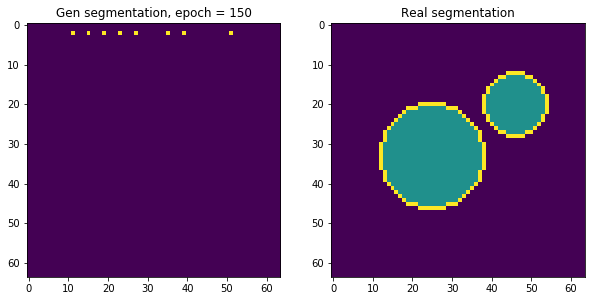

epoch - 150, loss - 5.023853302
epoch - 151, loss - 5.00731372833
epoch - 152, loss - 5.01132249832
epoch - 153, loss - 5.01616477966
epoch - 154, loss - 4.9948091507
epoch - 155, loss - 4.98528909683
epoch - 156, loss - 4.98296546936
epoch - 157, loss - 4.98435211182
epoch - 158, loss - 4.97998523712
epoch - 159, loss - 4.95011043549
epoch - 160, loss - 4.95740652084
epoch - 161, loss - 5.04003143311
epoch - 162, loss - 4.95720863342
epoch - 163, loss - 4.98102712631
epoch - 164, loss - 4.95056772232
epoch - 165, loss - 4.9386920929
epoch - 166, loss - 4.92220449448
epoch - 167, loss - 4.89108896255
epoch - 168, loss - 4.88299417496
epoch - 169, loss - 4.85618877411
epoch - 170, loss - 4.84548473358
epoch - 171, loss - 4.82441806793
epoch - 172, loss - 4.84061956406
epoch - 173, loss - 4.94375896454
epoch - 174, loss - 4.83908224106
epoch - 175, loss - 4.84445381165
epoch - 176, loss - 4.82471942902
epoch - 177, loss - 4.76881837845
epoch - 178, loss - 4.76179599762
epoch - 179, loss 

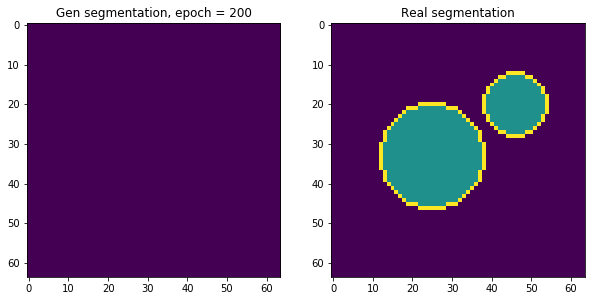

epoch - 200, loss - 4.42296123505
epoch - 201, loss - 4.40296554565
epoch - 202, loss - 4.38652658463
epoch - 203, loss - 4.37545776367
epoch - 204, loss - 4.35605621338
epoch - 205, loss - 4.34704208374
epoch - 206, loss - 4.33036661148
epoch - 207, loss - 4.32401227951
epoch - 208, loss - 4.3111333847
epoch - 209, loss - 4.30128192902
epoch - 210, loss - 4.29195737839
epoch - 211, loss - 4.28000593185
epoch - 212, loss - 4.27469730377
epoch - 213, loss - 4.26466417313
epoch - 214, loss - 4.25541305542
epoch - 215, loss - 4.24732732773
epoch - 216, loss - 4.23732280731
epoch - 217, loss - 4.23090267181
epoch - 218, loss - 4.22328996658
epoch - 219, loss - 4.21470212936
epoch - 220, loss - 4.20951461792
epoch - 221, loss - 4.20185470581
epoch - 222, loss - 4.19719457626
epoch - 223, loss - 4.19297027588
epoch - 224, loss - 4.19711923599
epoch - 225, loss - 4.20590400696
epoch - 226, loss - 4.18095445633
epoch - 227, loss - 4.16444587708
epoch - 228, loss - 4.1619849205
epoch - 229, los

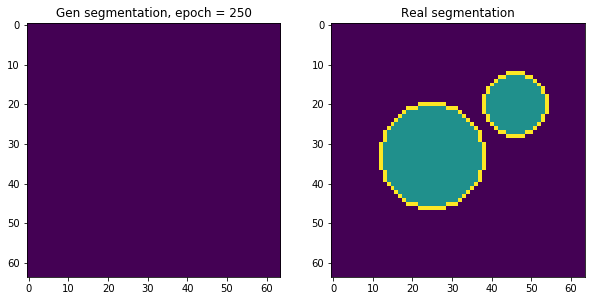

epoch - 250, loss - 4.095703125
epoch - 251, loss - 4.09531497955
epoch - 252, loss - 4.07574939728
epoch - 253, loss - 4.0425028801
epoch - 254, loss - 4.06980895996
epoch - 255, loss - 4.05348300934
epoch - 256, loss - 4.0401391983
epoch - 257, loss - 4.04445648193
epoch - 258, loss - 4.0273680687
epoch - 259, loss - 4.03106832504
epoch - 260, loss - 4.01560974121
epoch - 261, loss - 4.02090787888
epoch - 262, loss - 4.00673151016
epoch - 263, loss - 4.00806999207
epoch - 264, loss - 3.99851202965
epoch - 265, loss - 3.99757432938
epoch - 266, loss - 3.99023914337
epoch - 267, loss - 3.98676013947
epoch - 268, loss - 3.9812309742
epoch - 269, loss - 3.97752714157
epoch - 270, loss - 3.97199749947
epoch - 271, loss - 3.96846032143
epoch - 272, loss - 3.96358680725
epoch - 273, loss - 3.96007728577
epoch - 274, loss - 3.95605659485
epoch - 275, loss - 3.95014595985
epoch - 276, loss - 3.94689893723
epoch - 277, loss - 3.94240045547
epoch - 278, loss - 3.93919181824
epoch - 279, loss - 

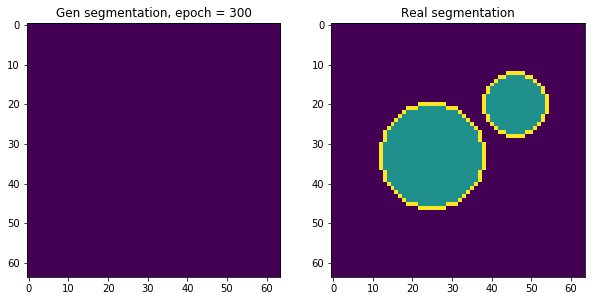

epoch - 300, loss - 3.86490392685
epoch - 301, loss - 3.86088514328
epoch - 302, loss - 3.85353636742
epoch - 303, loss - 3.84747934341
epoch - 304, loss - 3.84512710571
epoch - 305, loss - 3.83917546272
epoch - 306, loss - 3.83742046356
epoch - 307, loss - 3.83802461624
epoch - 308, loss - 3.83360671997
epoch - 309, loss - 3.83959197998
epoch - 310, loss - 3.83649325371
epoch - 311, loss - 3.83180427551
epoch - 312, loss - 3.82201814651
epoch - 313, loss - 3.81865739822
epoch - 314, loss - 3.82457995415
epoch - 315, loss - 3.81903100014
epoch - 316, loss - 3.81721401215
epoch - 317, loss - 3.82100963593
epoch - 318, loss - 3.80149269104
epoch - 319, loss - 3.80234861374
epoch - 320, loss - 3.80485892296
epoch - 321, loss - 3.79937791824
epoch - 322, loss - 3.80394005775
epoch - 323, loss - 3.79810142517
epoch - 324, loss - 3.80907034874
epoch - 325, loss - 3.81270885468
epoch - 326, loss - 3.78564214706
epoch - 327, loss - 3.78849029541
epoch - 328, loss - 3.78186869621
epoch - 329, l

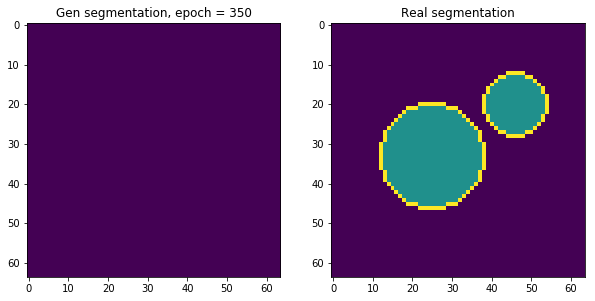

epoch - 350, loss - 3.68758869171
epoch - 351, loss - 3.67409276962
epoch - 352, loss - 3.67817878723
epoch - 353, loss - 3.68796420097
epoch - 354, loss - 3.67944312096
epoch - 355, loss - 3.67487192154
epoch - 356, loss - 3.68105578423
epoch - 357, loss - 3.66248893738
epoch - 358, loss - 3.66295671463
epoch - 359, loss - 3.67145776749
epoch - 360, loss - 3.65659403801
epoch - 361, loss - 3.64016747475
epoch - 362, loss - 3.64295148849
epoch - 363, loss - 3.63140702248
epoch - 364, loss - 3.62711167336
epoch - 365, loss - 3.62985229492
epoch - 366, loss - 3.61430549622
epoch - 367, loss - 3.61320900917
epoch - 368, loss - 3.60763120651
epoch - 369, loss - 3.59934926033
epoch - 370, loss - 3.59855318069
epoch - 371, loss - 3.59290361404
epoch - 372, loss - 3.59071135521
epoch - 373, loss - 3.59291124344
epoch - 374, loss - 3.59755253792
epoch - 375, loss - 3.59072232246
epoch - 376, loss - 3.58229184151
epoch - 377, loss - 3.56839561462
epoch - 378, loss - 3.56467485428
epoch - 379, l

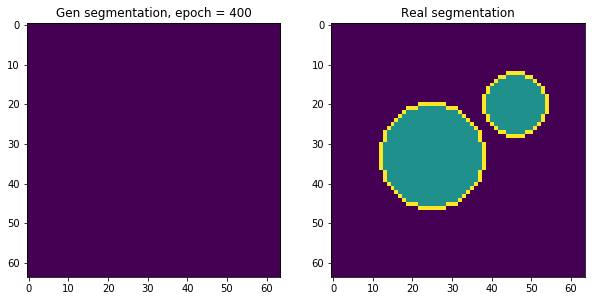

epoch - 400, loss - 3.48697662354
epoch - 401, loss - 3.48173379898
epoch - 402, loss - 3.47688364983
epoch - 403, loss - 3.46722483635
epoch - 404, loss - 3.46225118637
epoch - 405, loss - 3.45482206345
epoch - 406, loss - 3.44857192039
epoch - 407, loss - 3.44933176041
epoch - 408, loss - 3.44917964935
epoch - 409, loss - 3.44844865799
epoch - 410, loss - 3.4652364254
epoch - 411, loss - 3.51269435883
epoch - 412, loss - 3.51089715958
epoch - 413, loss - 3.47574520111
epoch - 414, loss - 3.44944643974
epoch - 415, loss - 3.46048355103
epoch - 416, loss - 3.43505239487
epoch - 417, loss - 3.43836975098
epoch - 418, loss - 3.41640853882
epoch - 419, loss - 3.42249965668
epoch - 420, loss - 3.40439271927
epoch - 421, loss - 3.40417766571
epoch - 422, loss - 3.3950521946
epoch - 423, loss - 3.3864107132
epoch - 424, loss - 3.38311314583
epoch - 425, loss - 3.37229299545
epoch - 426, loss - 3.37051296234
epoch - 427, loss - 3.36693286896
epoch - 428, loss - 3.37326288223
epoch - 429, loss

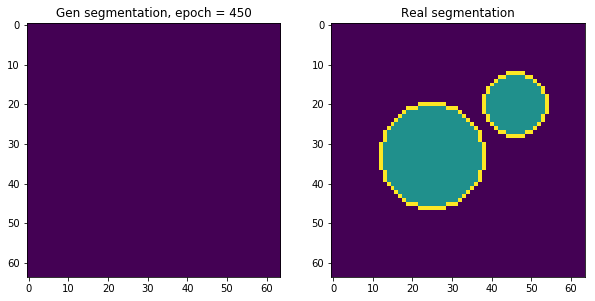

epoch - 450, loss - 3.26300549507
epoch - 451, loss - 3.26558589935
epoch - 452, loss - 3.26573848724
epoch - 453, loss - 3.25477409363
epoch - 454, loss - 3.25714015961
epoch - 455, loss - 3.25204658508
epoch - 456, loss - 3.24648475647
epoch - 457, loss - 3.23697161674
epoch - 458, loss - 3.23486614227
epoch - 459, loss - 3.23105621338
epoch - 460, loss - 3.22996854782
epoch - 461, loss - 3.21977066994
epoch - 462, loss - 3.23028182983
epoch - 463, loss - 3.23699069023
epoch - 464, loss - 3.23655748367
epoch - 465, loss - 3.21572780609
epoch - 466, loss - 3.21352458
epoch - 467, loss - 3.21643352509
epoch - 468, loss - 3.20288395882
epoch - 469, loss - 3.17964458466
epoch - 470, loss - 3.18360209465
epoch - 471, loss - 3.17086148262
epoch - 472, loss - 3.16069293022
epoch - 473, loss - 3.16307115555
epoch - 474, loss - 3.15786623955
epoch - 475, loss - 3.16193366051
epoch - 476, loss - 3.1619591713
epoch - 477, loss - 3.16743326187
epoch - 478, loss - 3.19261479378
epoch - 479, loss 

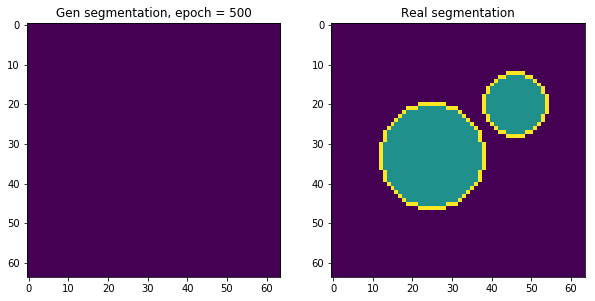

epoch - 500, loss - 3.0533618927
epoch - 501, loss - 3.04860877991
epoch - 502, loss - 3.06404304504
epoch - 503, loss - 3.05801296234
epoch - 504, loss - 3.04814648628
epoch - 505, loss - 3.04240727425
epoch - 506, loss - 3.02898955345
epoch - 507, loss - 3.02678894997
epoch - 508, loss - 3.03343391418
epoch - 509, loss - 3.04045391083
epoch - 510, loss - 3.02194976807
epoch - 511, loss - 3.01608967781
epoch - 512, loss - 3.01695537567
epoch - 513, loss - 3.01970458031
epoch - 514, loss - 3.0010766983
epoch - 515, loss - 2.9838809967
epoch - 516, loss - 2.98321127892
epoch - 517, loss - 2.98065781593
epoch - 518, loss - 2.99010586739
epoch - 519, loss - 3.00672626495
epoch - 520, loss - 2.99695491791
epoch - 521, loss - 2.97562265396
epoch - 522, loss - 2.96205615997
epoch - 523, loss - 2.97146821022
epoch - 524, loss - 2.9572095871
epoch - 525, loss - 2.96567678452
epoch - 526, loss - 3.00927305222
epoch - 527, loss - 3.00722455978
epoch - 528, loss - 3.03757166862
epoch - 529, loss 

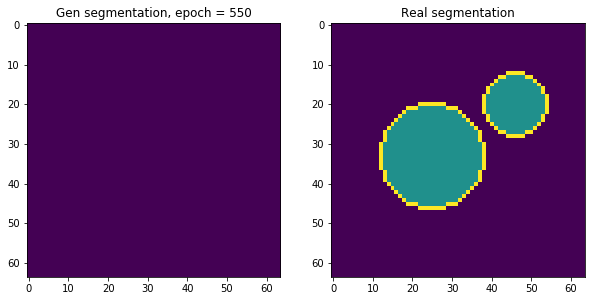

epoch - 550, loss - 2.85358524323
epoch - 551, loss - 2.84592080116
epoch - 552, loss - 2.84493589401
epoch - 553, loss - 2.84185552597
epoch - 554, loss - 2.85447263718
epoch - 555, loss - 2.89127445221
epoch - 556, loss - 2.90353894234
epoch - 557, loss - 2.86117076874
epoch - 558, loss - 2.84745407104
epoch - 559, loss - 2.83767771721
epoch - 560, loss - 2.83082056046
epoch - 561, loss - 2.81389784813
epoch - 562, loss - 2.81100106239
epoch - 563, loss - 2.79688119888
epoch - 564, loss - 2.79932594299
epoch - 565, loss - 2.80721950531
epoch - 566, loss - 2.81149983406
epoch - 567, loss - 2.82987785339
epoch - 568, loss - 2.81198740005
epoch - 569, loss - 2.78226208687
epoch - 570, loss - 2.79250717163
epoch - 571, loss - 2.79320001602
epoch - 572, loss - 2.78925991058
epoch - 573, loss - 2.77945637703
epoch - 574, loss - 2.78699064255
epoch - 575, loss - 2.7811589241
epoch - 576, loss - 2.76639556885
epoch - 577, loss - 2.77634763718
epoch - 578, loss - 2.7829284668
epoch - 579, los

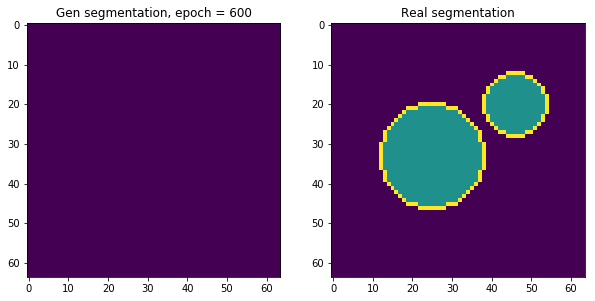

epoch - 600, loss - 2.68189191818
epoch - 601, loss - 2.67783117294
epoch - 602, loss - 2.67931985855
epoch - 603, loss - 2.68902778625
epoch - 604, loss - 2.67076086998
epoch - 605, loss - 2.66248083115
epoch - 606, loss - 2.65550875664
epoch - 607, loss - 2.64272618294
epoch - 608, loss - 2.6403439045
epoch - 609, loss - 2.63694095612
epoch - 610, loss - 2.63462257385
epoch - 611, loss - 2.64163565636
epoch - 612, loss - 2.66065406799
epoch - 613, loss - 2.64981889725
epoch - 614, loss - 2.65153598785
epoch - 615, loss - 2.64612603188
epoch - 616, loss - 2.62742853165
epoch - 617, loss - 2.64115929604
epoch - 618, loss - 2.63756132126
epoch - 619, loss - 2.61442899704
epoch - 620, loss - 2.62740135193
epoch - 621, loss - 2.61913299561
epoch - 622, loss - 2.61436772346
epoch - 623, loss - 2.63216114044
epoch - 624, loss - 2.64542102814
epoch - 625, loss - 2.63732838631
epoch - 626, loss - 2.62244987488
epoch - 627, loss - 2.61000204086
epoch - 628, loss - 2.5909473896
epoch - 629, los

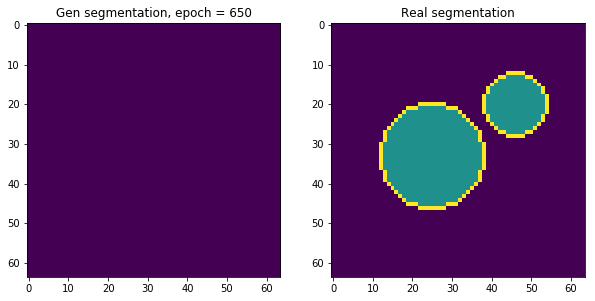

epoch - 650, loss - 2.54757833481
epoch - 651, loss - 2.51842355728
epoch - 652, loss - 2.51760149002
epoch - 653, loss - 2.51836848259
epoch - 654, loss - 2.50226521492
epoch - 655, loss - 2.50302743912
epoch - 656, loss - 2.49681401253
epoch - 657, loss - 2.49945139885
epoch - 658, loss - 2.50294494629
epoch - 659, loss - 2.5122988224
epoch - 660, loss - 2.5132753849
epoch - 661, loss - 2.49468326569
epoch - 662, loss - 2.48051595688
epoch - 663, loss - 2.48193335533
epoch - 664, loss - 2.48790192604
epoch - 665, loss - 2.5061955452
epoch - 666, loss - 2.51169157028
epoch - 667, loss - 2.54110264778
epoch - 668, loss - 2.49037671089
epoch - 669, loss - 2.47494316101
epoch - 670, loss - 2.4714987278
epoch - 671, loss - 2.46060657501
epoch - 672, loss - 2.46952867508
epoch - 673, loss - 2.44953560829
epoch - 674, loss - 2.45573782921
epoch - 675, loss - 2.43795156479
epoch - 676, loss - 2.43926739693
epoch - 677, loss - 2.43882584572
epoch - 678, loss - 2.4308822155
epoch - 679, loss -

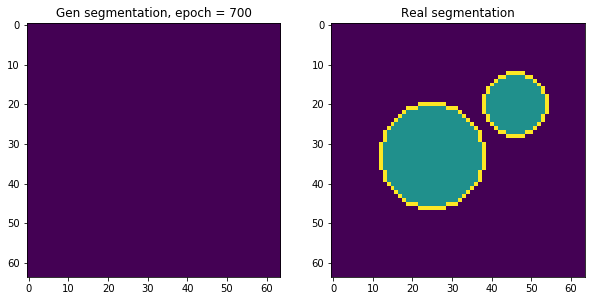

epoch - 700, loss - 2.37883973122
epoch - 701, loss - 2.37734866142
epoch - 702, loss - 2.37104940414
epoch - 703, loss - 2.37003517151
epoch - 704, loss - 2.3593006134
epoch - 705, loss - 2.36043977737
epoch - 706, loss - 2.36851787567
epoch - 707, loss - 2.35369157791
epoch - 708, loss - 2.3677380085
epoch - 709, loss - 2.38990592957
epoch - 710, loss - 2.38428926468
epoch - 711, loss - 2.3628282547
epoch - 712, loss - 2.36898732185
epoch - 713, loss - 2.36615586281
epoch - 714, loss - 2.35139369965
epoch - 715, loss - 2.33439850807
epoch - 716, loss - 2.34050536156
epoch - 717, loss - 2.33707737923
epoch - 718, loss - 2.33182406425
epoch - 719, loss - 2.33296394348
epoch - 720, loss - 2.33990263939
epoch - 721, loss - 2.32557201385
epoch - 722, loss - 2.3329410553
epoch - 723, loss - 2.35251092911
epoch - 724, loss - 2.34671783447
epoch - 725, loss - 2.31944942474
epoch - 726, loss - 2.33839201927
epoch - 727, loss - 2.35782790184
epoch - 728, loss - 2.34175944328
epoch - 729, loss 

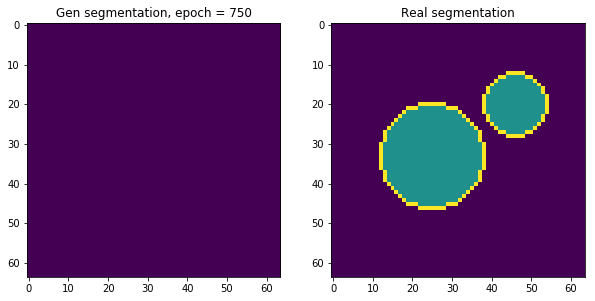

epoch - 750, loss - 2.24379730225
epoch - 751, loss - 2.23867106438
epoch - 752, loss - 2.24320650101
epoch - 753, loss - 2.24044966698
epoch - 754, loss - 2.2433321476
epoch - 755, loss - 2.24336147308
epoch - 756, loss - 2.23534059525
epoch - 757, loss - 2.25225830078
epoch - 758, loss - 2.24528121948
epoch - 759, loss - 2.24928450584
epoch - 760, loss - 2.23707389832
epoch - 761, loss - 2.23082923889
epoch - 762, loss - 2.22614955902
epoch - 763, loss - 2.23779249191
epoch - 764, loss - 2.22328591347
epoch - 765, loss - 2.22943592072
epoch - 766, loss - 2.24134135246
epoch - 767, loss - 2.21398758888
epoch - 768, loss - 2.22114610672
epoch - 769, loss - 2.23355078697
epoch - 770, loss - 2.2229924202
epoch - 771, loss - 2.21395778656
epoch - 772, loss - 2.20876812935
epoch - 773, loss - 2.21322536469
epoch - 774, loss - 2.20725059509
epoch - 775, loss - 2.21982097626
epoch - 776, loss - 2.23368191719
epoch - 777, loss - 2.20753312111
epoch - 778, loss - 2.19071054459
epoch - 779, los

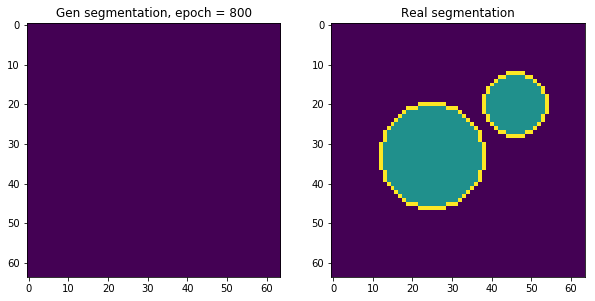

epoch - 800, loss - 2.16511487961
epoch - 801, loss - 2.16044807434
epoch - 802, loss - 2.1539645195
epoch - 803, loss - 2.14351797104
epoch - 804, loss - 2.13465356827
epoch - 805, loss - 2.14926433563
epoch - 806, loss - 2.15550374985
epoch - 807, loss - 2.1481359005
epoch - 808, loss - 2.14093995094
epoch - 809, loss - 2.13634705544
epoch - 810, loss - 2.12993478775
epoch - 811, loss - 2.11166715622
epoch - 812, loss - 2.11359262466
epoch - 813, loss - 2.11865305901
epoch - 814, loss - 2.11653470993
epoch - 815, loss - 2.11565065384
epoch - 816, loss - 2.13081598282
epoch - 817, loss - 2.14209771156
epoch - 818, loss - 2.14023470879
epoch - 819, loss - 2.12845420837
epoch - 820, loss - 2.10945534706
epoch - 821, loss - 2.10555720329
epoch - 822, loss - 2.11027693748
epoch - 823, loss - 2.13234710693
epoch - 824, loss - 2.11273050308
epoch - 825, loss - 2.11289548874
epoch - 826, loss - 2.11853218079
epoch - 827, loss - 2.11779642105
epoch - 828, loss - 2.09257221222
epoch - 829, los

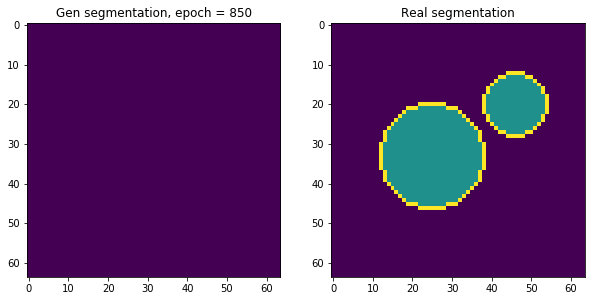

epoch - 850, loss - 2.06207156181
epoch - 851, loss - 2.04683232307
epoch - 852, loss - 2.03450298309
epoch - 853, loss - 2.04398775101
epoch - 854, loss - 2.04877090454
epoch - 855, loss - 2.0441262722
epoch - 856, loss - 2.04339408875
epoch - 857, loss - 2.0398106575
epoch - 858, loss - 2.03342318535
epoch - 859, loss - 2.03674221039
epoch - 860, loss - 2.04541635513
epoch - 861, loss - 2.06068944931
epoch - 862, loss - 2.05042695999
epoch - 863, loss - 2.03637742996
epoch - 864, loss - 2.04245901108
epoch - 865, loss - 2.05353498459
epoch - 866, loss - 2.05139064789
epoch - 867, loss - 2.02930212021
epoch - 868, loss - 2.03335380554
epoch - 869, loss - 2.02970600128
epoch - 870, loss - 2.03690576553
epoch - 871, loss - 2.05526638031
epoch - 872, loss - 2.077511549
epoch - 873, loss - 2.03474330902
epoch - 874, loss - 2.0219950676
epoch - 875, loss - 2.0352025032
epoch - 876, loss - 2.02875161171
epoch - 877, loss - 2.0225417614
epoch - 878, loss - 1.99653697014
epoch - 879, loss - 1

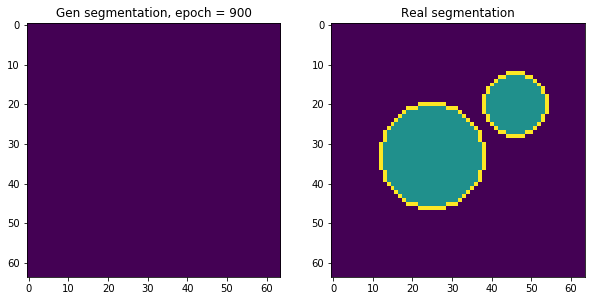

epoch - 900, loss - 1.96881318092
epoch - 901, loss - 1.97255134583
epoch - 902, loss - 1.97666156292
epoch - 903, loss - 1.96733379364
epoch - 904, loss - 1.96227741241
epoch - 905, loss - 1.9555709362
epoch - 906, loss - 1.95564723015
epoch - 907, loss - 1.95171666145
epoch - 908, loss - 1.94741630554
epoch - 909, loss - 1.94250941277
epoch - 910, loss - 1.94364571571
epoch - 911, loss - 1.94930171967
epoch - 912, loss - 1.95861971378
epoch - 913, loss - 1.96077132225
epoch - 914, loss - 1.95481193066
epoch - 915, loss - 1.94145560265
epoch - 916, loss - 1.93506491184
epoch - 917, loss - 1.93553805351
epoch - 918, loss - 1.93277597427
epoch - 919, loss - 1.93174791336
epoch - 920, loss - 1.93692088127
epoch - 921, loss - 1.95246684551
epoch - 922, loss - 1.95929551125
epoch - 923, loss - 1.96254968643
epoch - 924, loss - 1.96599602699
epoch - 925, loss - 1.97368633747
epoch - 926, loss - 1.94718956947
epoch - 927, loss - 1.95853042603
epoch - 928, loss - 1.95770835876
epoch - 929, lo

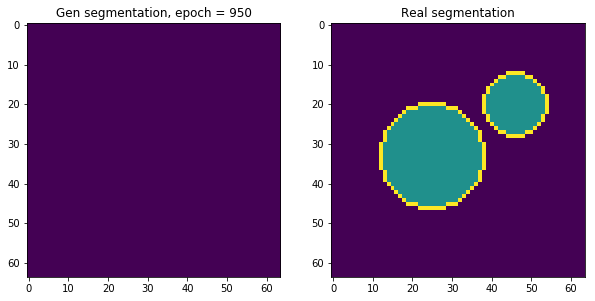

epoch - 950, loss - 1.90705537796
epoch - 951, loss - 1.90855956078
epoch - 952, loss - 1.90674424171
epoch - 953, loss - 1.88317990303
epoch - 954, loss - 1.88536286354
epoch - 955, loss - 1.88666272163
epoch - 956, loss - 1.87489700317
epoch - 957, loss - 1.88442206383
epoch - 958, loss - 1.89363718033
epoch - 959, loss - 1.89406323433
epoch - 960, loss - 1.887622118
epoch - 961, loss - 1.88796305656
epoch - 962, loss - 1.87475657463
epoch - 963, loss - 1.87852191925
epoch - 964, loss - 1.88012850285
epoch - 965, loss - 1.87590432167
epoch - 966, loss - 1.87308216095
epoch - 967, loss - 1.88126325607
epoch - 968, loss - 1.90326762199
epoch - 969, loss - 1.90745282173
epoch - 970, loss - 1.87058281898
epoch - 971, loss - 1.85545754433
epoch - 972, loss - 1.8603374958
epoch - 973, loss - 1.86083579063
epoch - 974, loss - 1.84489703178
epoch - 975, loss - 1.83700478077
epoch - 976, loss - 1.8458827734
epoch - 977, loss - 1.83820819855
epoch - 978, loss - 1.83178400993
epoch - 979, loss 

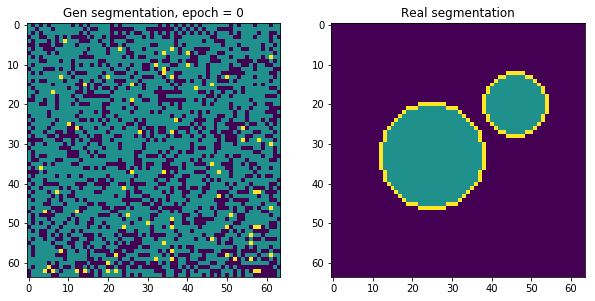

epoch - 0, loss - 116.656593323
epoch - 1, loss - 100.955337524
epoch - 2, loss - 88.4847793579
epoch - 3, loss - 78.0927886963
epoch - 4, loss - 69.3135452271
epoch - 5, loss - 61.790348053
epoch - 6, loss - 55.399848938
epoch - 7, loss - 49.9298171997
epoch - 8, loss - 45.1489105225
epoch - 9, loss - 40.872303009
epoch - 10, loss - 36.9975242615
epoch - 11, loss - 33.5550918579
epoch - 12, loss - 30.5027866364
epoch - 13, loss - 27.8019790649
epoch - 14, loss - 25.3773117065
epoch - 15, loss - 23.199092865
epoch - 16, loss - 21.2403202057
epoch - 17, loss - 19.4854621887
epoch - 18, loss - 17.9204349518
epoch - 19, loss - 16.5360336304
epoch - 20, loss - 15.3273916245
epoch - 21, loss - 14.2831363678
epoch - 22, loss - 13.3877067566
epoch - 23, loss - 12.6189317703
epoch - 24, loss - 11.9510326385
epoch - 25, loss - 11.3602991104
epoch - 26, loss - 10.8300161362
epoch - 27, loss - 10.3543176651
epoch - 28, loss - 9.93091583252
epoch - 29, loss - 9.55780982971
epoch - 30, loss - 9.230

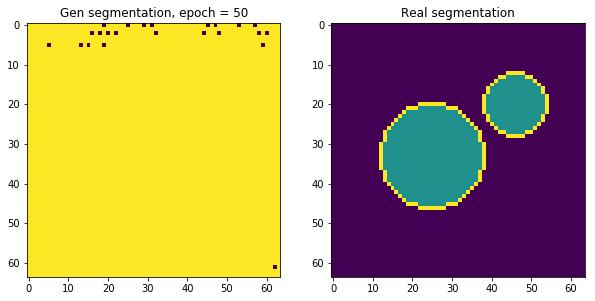

epoch - 50, loss - 6.66211223602
epoch - 51, loss - 6.61964988708
epoch - 52, loss - 6.57220077515
epoch - 53, loss - 6.53451871872
epoch - 54, loss - 6.5010099411
epoch - 55, loss - 6.46871757507
epoch - 56, loss - 6.43841314316
epoch - 57, loss - 6.41149711609
epoch - 58, loss - 6.38731384277
epoch - 59, loss - 6.36373901367
epoch - 60, loss - 6.34145641327
epoch - 61, loss - 6.32147455215
epoch - 62, loss - 6.30391740799
epoch - 63, loss - 6.28768968582
epoch - 64, loss - 6.27241420746
epoch - 65, loss - 6.25891208649
epoch - 66, loss - 6.24713134766
epoch - 67, loss - 6.23626184464
epoch - 68, loss - 6.22601699829
epoch - 69, loss - 6.2166686058
epoch - 70, loss - 6.20826530457
epoch - 71, loss - 6.20031261444
epoch - 72, loss - 6.19267272949
epoch - 73, loss - 6.18557357788
epoch - 74, loss - 6.17907571793
epoch - 75, loss - 6.17283153534
epoch - 76, loss - 6.1667599678
epoch - 77, loss - 6.16107463837
epoch - 78, loss - 6.15570354462
epoch - 79, loss - 6.15055179596
epoch - 80, l

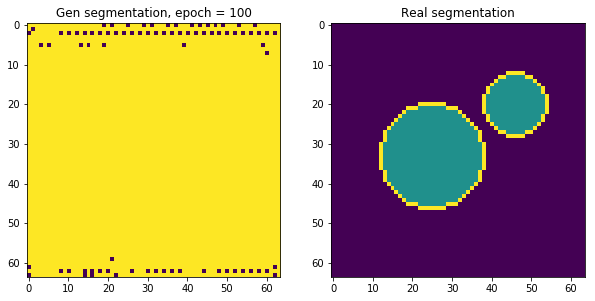

epoch - 100, loss - 6.07688236237
epoch - 101, loss - 6.07438182831
epoch - 102, loss - 6.07192659378
epoch - 103, loss - 6.06950950623
epoch - 104, loss - 6.06711912155
epoch - 105, loss - 6.06476020813
epoch - 106, loss - 6.06244325638
epoch - 107, loss - 6.06016159058
epoch - 108, loss - 6.05790519714
epoch - 109, loss - 6.05567312241
epoch - 110, loss - 6.05346441269
epoch - 111, loss - 6.05127716064
epoch - 112, loss - 6.04911804199
epoch - 113, loss - 6.04698038101
epoch - 114, loss - 6.04485845566
epoch - 115, loss - 6.04275655746
epoch - 116, loss - 6.04067516327
epoch - 117, loss - 6.03861570358
epoch - 118, loss - 6.03657388687
epoch - 119, loss - 6.03455018997
epoch - 120, loss - 6.03254079819
epoch - 121, loss - 6.03054523468
epoch - 122, loss - 6.02857065201
epoch - 123, loss - 6.02660608292
epoch - 124, loss - 6.02464962006
epoch - 125, loss - 6.02270889282
epoch - 126, loss - 6.0207862854
epoch - 127, loss - 6.01886749268
epoch - 128, loss - 6.01695775986
epoch - 129, lo

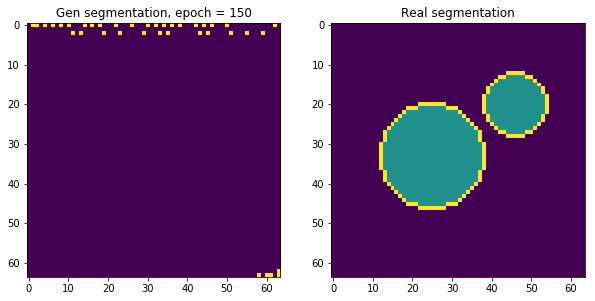

epoch - 150, loss - 5.97729539871
epoch - 151, loss - 5.97557592392
epoch - 152, loss - 5.97386550903
epoch - 153, loss - 5.97216176987
epoch - 154, loss - 5.97046136856
epoch - 155, loss - 5.96876573563
epoch - 156, loss - 5.96707725525
epoch - 157, loss - 5.96539306641
epoch - 158, loss - 5.96371459961
epoch - 159, loss - 5.96204137802
epoch - 160, loss - 5.96037101746
epoch - 161, loss - 5.95870876312
epoch - 162, loss - 5.95704841614
epoch - 163, loss - 5.95539140701
epoch - 164, loss - 5.95373630524
epoch - 165, loss - 5.95208454132
epoch - 166, loss - 5.95043325424
epoch - 167, loss - 5.94878673553
epoch - 168, loss - 5.94714260101
epoch - 169, loss - 5.94549846649
epoch - 170, loss - 5.9438533783
epoch - 171, loss - 5.94220495224
epoch - 172, loss - 5.94056081772
epoch - 173, loss - 5.93891525269
epoch - 174, loss - 5.93727207184
epoch - 175, loss - 5.9356303215
epoch - 176, loss - 5.93399143219
epoch - 177, loss - 5.93235492706
epoch - 178, loss - 5.93072462082
epoch - 179, los

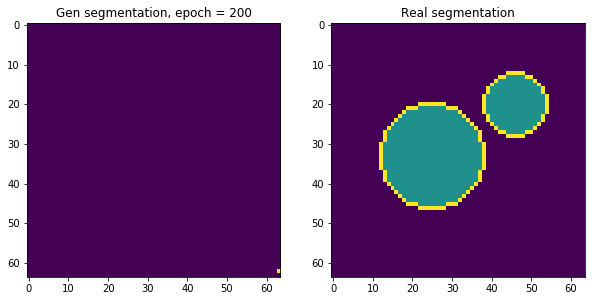

epoch - 200, loss - 5.89511489868
epoch - 201, loss - 5.89349794388
epoch - 202, loss - 5.89187908173
epoch - 203, loss - 5.89026069641
epoch - 204, loss - 5.88864183426
epoch - 205, loss - 5.88702106476
epoch - 206, loss - 5.88540172577
epoch - 207, loss - 5.88377761841
epoch - 208, loss - 5.88215065002
epoch - 209, loss - 5.88051843643
epoch - 210, loss - 5.87888479233
epoch - 211, loss - 5.87724351883
epoch - 212, loss - 5.87560510635
epoch - 213, loss - 5.87396430969
epoch - 214, loss - 5.87232065201
epoch - 215, loss - 5.87068080902
epoch - 216, loss - 5.8690328598
epoch - 217, loss - 5.86738634109
epoch - 218, loss - 5.86574029922
epoch - 219, loss - 5.86408996582
epoch - 220, loss - 5.86244058609
epoch - 221, loss - 5.86078739166
epoch - 222, loss - 5.85913133621
epoch - 223, loss - 5.85747337341
epoch - 224, loss - 5.85581684113
epoch - 225, loss - 5.85415744781
epoch - 226, loss - 5.85249328613
epoch - 227, loss - 5.85082626343
epoch - 228, loss - 5.84915924072
epoch - 229, lo

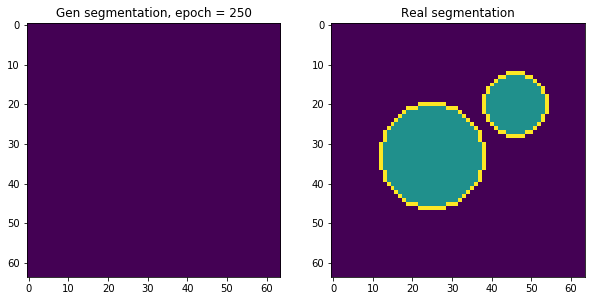

epoch - 250, loss - 5.81243181229
epoch - 251, loss - 5.81074762344
epoch - 252, loss - 5.80906009674
epoch - 253, loss - 5.80736970901
epoch - 254, loss - 5.80567169189
epoch - 255, loss - 5.80397224426
epoch - 256, loss - 5.80227041245
epoch - 257, loss - 5.80056905746
epoch - 258, loss - 5.79886579514
epoch - 259, loss - 5.79716539383
epoch - 260, loss - 5.79546451569
epoch - 261, loss - 5.79376173019
epoch - 262, loss - 5.79205179214
epoch - 263, loss - 5.79033613205
epoch - 264, loss - 5.78861808777
epoch - 265, loss - 5.78689479828
epoch - 266, loss - 5.78517532349
epoch - 267, loss - 5.78345012665
epoch - 268, loss - 5.78172683716
epoch - 269, loss - 5.77999973297
epoch - 270, loss - 5.77827119827
epoch - 271, loss - 5.77653455734
epoch - 272, loss - 5.77479696274
epoch - 273, loss - 5.77305316925
epoch - 274, loss - 5.77130699158
epoch - 275, loss - 5.76955986023
epoch - 276, loss - 5.7678027153
epoch - 277, loss - 5.76604652405
epoch - 278, loss - 5.76427936554
epoch - 279, lo

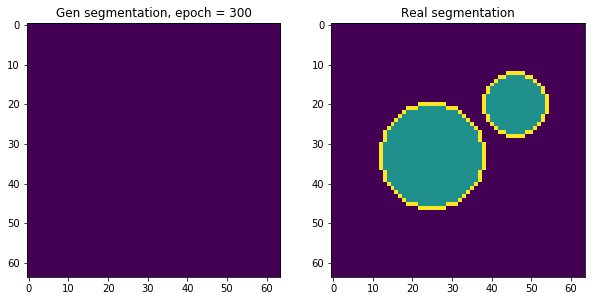

epoch - 300, loss - 5.72400808334
epoch - 301, loss - 5.72208786011
epoch - 302, loss - 5.72015953064
epoch - 303, loss - 5.71821403503
epoch - 304, loss - 5.71627092361
epoch - 305, loss - 5.71429252625
epoch - 306, loss - 5.71231460571
epoch - 307, loss - 5.71032142639
epoch - 308, loss - 5.70831108093
epoch - 309, loss - 5.70628547668
epoch - 310, loss - 5.70424318314
epoch - 311, loss - 5.7021946907
epoch - 312, loss - 5.70011711121
epoch - 313, loss - 5.69806146622
epoch - 314, loss - 5.69596242905
epoch - 315, loss - 5.69388389587
epoch - 316, loss - 5.69174432755
epoch - 317, loss - 5.68963575363
epoch - 318, loss - 5.68747377396
epoch - 319, loss - 5.68532705307
epoch - 320, loss - 5.6831111908
epoch - 321, loss - 5.68090820312
epoch - 322, loss - 5.67866611481
epoch - 323, loss - 5.67644119263
epoch - 324, loss - 5.67412853241
epoch - 325, loss - 5.67184495926
epoch - 326, loss - 5.66947698593
epoch - 327, loss - 5.66715288162
epoch - 328, loss - 5.66475629807
epoch - 329, los

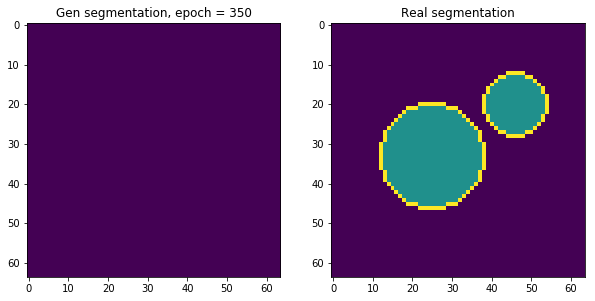

epoch - 350, loss - 5.59965085983
epoch - 351, loss - 5.59599113464
epoch - 352, loss - 5.5923409462
epoch - 353, loss - 5.58859729767
epoch - 354, loss - 5.5850687027
epoch - 355, loss - 5.58126401901
epoch - 356, loss - 5.5775437355
epoch - 357, loss - 5.57391309738
epoch - 358, loss - 5.57032966614
epoch - 359, loss - 5.56678676605
epoch - 360, loss - 5.56323194504
epoch - 361, loss - 5.55969429016
epoch - 362, loss - 5.55615997314
epoch - 363, loss - 5.5525636673
epoch - 364, loss - 5.54895925522
epoch - 365, loss - 5.54524993896
epoch - 366, loss - 5.54145860672
epoch - 367, loss - 5.53757619858
epoch - 368, loss - 5.53356742859
epoch - 369, loss - 5.52971315384
epoch - 370, loss - 5.52540874481
epoch - 371, loss - 5.52113628387
epoch - 372, loss - 5.51651334763
epoch - 373, loss - 5.51197290421
epoch - 374, loss - 5.50708961487
epoch - 375, loss - 5.50218105316
epoch - 376, loss - 5.49690818787
epoch - 377, loss - 5.49150085449
epoch - 378, loss - 5.48567724228
epoch - 379, loss 

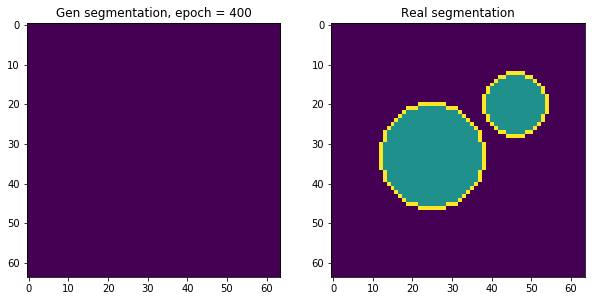

epoch - 400, loss - 5.26328516006
epoch - 401, loss - 5.2566280365
epoch - 402, loss - 5.25025367737
epoch - 403, loss - 5.24416399002
epoch - 404, loss - 5.2388176918
epoch - 405, loss - 5.2335691452
epoch - 406, loss - 5.22838973999
epoch - 407, loss - 5.22312164307
epoch - 408, loss - 5.2179851532
epoch - 409, loss - 5.21288108826
epoch - 410, loss - 5.20606613159
epoch - 411, loss - 5.2087225914
epoch - 412, loss - 5.2116150856
epoch - 413, loss - 5.2034945488
epoch - 414, loss - 5.19812393188
epoch - 415, loss - 5.19395112991
epoch - 416, loss - 5.18837738037
epoch - 417, loss - 5.18468904495
epoch - 418, loss - 5.18063831329
epoch - 419, loss - 5.17619609833
epoch - 420, loss - 5.17143535614
epoch - 421, loss - 5.16738605499
epoch - 422, loss - 5.16302633286
epoch - 423, loss - 5.15848493576
epoch - 424, loss - 5.15430164337
epoch - 425, loss - 5.14948272705
epoch - 426, loss - 5.14440393448
epoch - 427, loss - 5.13966846466
epoch - 428, loss - 5.13422489166
epoch - 429, loss - 5

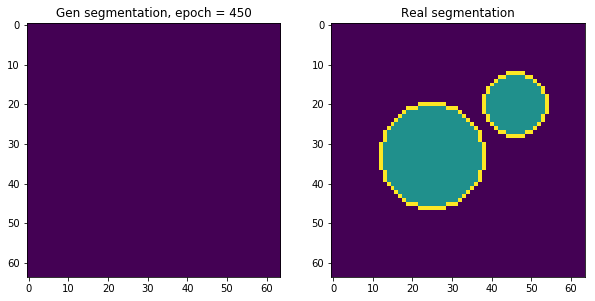

epoch - 450, loss - 4.97756195068
epoch - 451, loss - 4.96555709839
epoch - 452, loss - 5.03843593597
epoch - 453, loss - 4.98992109299
epoch - 454, loss - 4.96000814438
epoch - 455, loss - 4.94524908066
epoch - 456, loss - 4.94720172882
epoch - 457, loss - 4.89782857895
epoch - 458, loss - 4.90658903122
epoch - 459, loss - 4.88268899918
epoch - 460, loss - 4.85693311691
epoch - 461, loss - 4.85594749451
epoch - 462, loss - 4.84910392761
epoch - 463, loss - 4.88540840149
epoch - 464, loss - 4.81117534637
epoch - 465, loss - 4.78987503052
epoch - 466, loss - 4.78782224655
epoch - 467, loss - 4.7710018158
epoch - 468, loss - 4.73895740509
epoch - 469, loss - 4.74369287491
epoch - 470, loss - 4.70934677124
epoch - 471, loss - 4.69412279129
epoch - 472, loss - 4.68508338928
epoch - 473, loss - 4.65483617783
epoch - 474, loss - 4.65575408936
epoch - 475, loss - 4.63406181335
epoch - 476, loss - 4.61696815491
epoch - 477, loss - 4.60921287537
epoch - 478, loss - 4.59144496918
epoch - 479, lo

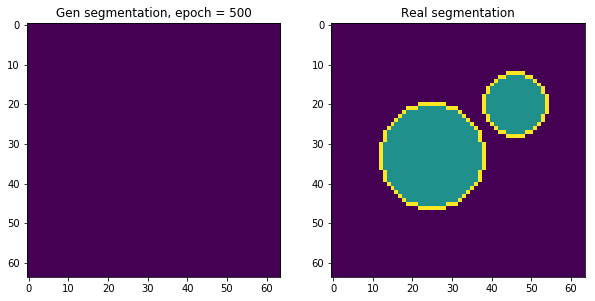

epoch - 500, loss - 4.36945486069
epoch - 501, loss - 4.37195634842
epoch - 502, loss - 4.33774757385
epoch - 503, loss - 4.35258436203
epoch - 504, loss - 4.34507989883
epoch - 505, loss - 4.32039499283
epoch - 506, loss - 4.33432674408
epoch - 507, loss - 4.30148649216
epoch - 508, loss - 4.30721616745
epoch - 509, loss - 4.28907394409
epoch - 510, loss - 4.28820371628
epoch - 511, loss - 4.27849721909
epoch - 512, loss - 4.27528142929
epoch - 513, loss - 4.26324033737
epoch - 514, loss - 4.25653171539
epoch - 515, loss - 4.25016546249
epoch - 516, loss - 4.24325847626
epoch - 517, loss - 4.23825550079
epoch - 518, loss - 4.23340320587
epoch - 519, loss - 4.23192167282
epoch - 520, loss - 4.230509758
epoch - 521, loss - 4.23323249817
epoch - 522, loss - 4.23853969574
epoch - 523, loss - 4.23305130005
epoch - 524, loss - 4.21429729462
epoch - 525, loss - 4.20742988586
epoch - 526, loss - 4.1971449852
epoch - 527, loss - 4.19475698471
epoch - 528, loss - 4.19838476181
epoch - 529, loss

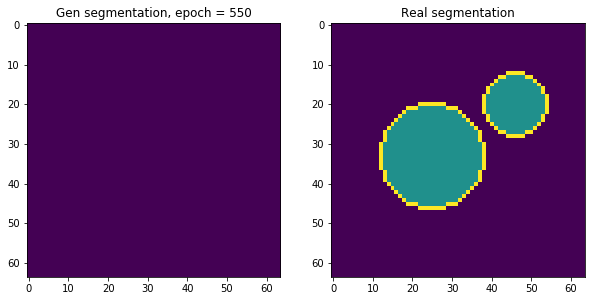

epoch - 550, loss - 4.09628391266
epoch - 551, loss - 4.09660339355
epoch - 552, loss - 4.08719158173
epoch - 553, loss - 4.09014129639
epoch - 554, loss - 4.08787822723
epoch - 555, loss - 4.09395933151
epoch - 556, loss - 4.08787870407
epoch - 557, loss - 4.07442522049
epoch - 558, loss - 4.06790494919
epoch - 559, loss - 4.07021474838
epoch - 560, loss - 4.06468343735
epoch - 561, loss - 4.05778217316
epoch - 562, loss - 4.05858421326
epoch - 563, loss - 4.05495595932
epoch - 564, loss - 4.04882240295
epoch - 565, loss - 4.05095243454
epoch - 566, loss - 4.04883670807
epoch - 567, loss - 4.04635858536
epoch - 568, loss - 4.05037546158
epoch - 569, loss - 4.04561853409
epoch - 570, loss - 4.03969717026
epoch - 571, loss - 4.0346660614
epoch - 572, loss - 4.02587890625
epoch - 573, loss - 4.0248003006
epoch - 574, loss - 4.02872800827
epoch - 575, loss - 4.02462768555
epoch - 576, loss - 4.01851224899
epoch - 577, loss - 4.01380062103
epoch - 578, loss - 4.01084518433
epoch - 579, los

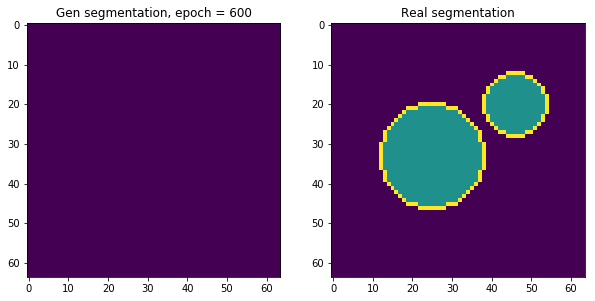

epoch - 600, loss - 4.07177305222
epoch - 601, loss - 4.14801263809
epoch - 602, loss - 4.03198432922
epoch - 603, loss - 4.04448461533
epoch - 604, loss - 4.04995727539
epoch - 605, loss - 4.08874320984
epoch - 606, loss - 4.23811721802
epoch - 607, loss - 4.07190752029
epoch - 608, loss - 4.09536790848
epoch - 609, loss - 4.07197761536
epoch - 610, loss - 4.0605711937
epoch - 611, loss - 4.03756666183
epoch - 612, loss - 4.04412984848
epoch - 613, loss - 4.02536582947
epoch - 614, loss - 4.02016162872
epoch - 615, loss - 4.01184177399
epoch - 616, loss - 4.00661325455
epoch - 617, loss - 3.99660134315
epoch - 618, loss - 3.99162340164
epoch - 619, loss - 3.98631215096
epoch - 620, loss - 3.98016381264
epoch - 621, loss - 3.98077583313
epoch - 622, loss - 3.96947336197
epoch - 623, loss - 3.96704554558
epoch - 624, loss - 3.96590161324
epoch - 625, loss - 3.95910906792
epoch - 626, loss - 3.95402359962
epoch - 627, loss - 3.95345664024
epoch - 628, loss - 3.95019340515
epoch - 629, lo

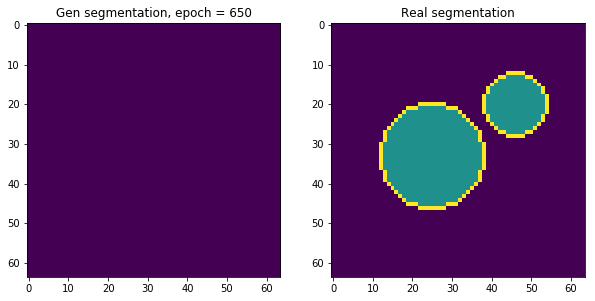

epoch - 650, loss - 3.89896345139
epoch - 651, loss - 3.89682435989
epoch - 652, loss - 3.89551353455
epoch - 653, loss - 3.89367175102
epoch - 654, loss - 3.8918170929
epoch - 655, loss - 3.89072394371
epoch - 656, loss - 3.88940382004
epoch - 657, loss - 3.88983559608
epoch - 658, loss - 3.89251542091
epoch - 659, loss - 3.89550280571
epoch - 660, loss - 3.89374303818
epoch - 661, loss - 3.8855304718
epoch - 662, loss - 3.88042140007
epoch - 663, loss - 3.88087630272
epoch - 664, loss - 3.88240933418
epoch - 665, loss - 3.87941288948
epoch - 666, loss - 3.87485074997
epoch - 667, loss - 3.87413597107
epoch - 668, loss - 3.87484169006
epoch - 669, loss - 3.87267160416
epoch - 670, loss - 3.86919879913
epoch - 671, loss - 3.86777687073
epoch - 672, loss - 3.86782598495
epoch - 673, loss - 3.86695146561
epoch - 674, loss - 3.86446738243
epoch - 675, loss - 3.86208438873
epoch - 676, loss - 3.86054420471
epoch - 677, loss - 3.85979366302
epoch - 678, loss - 3.85920476913
epoch - 679, los

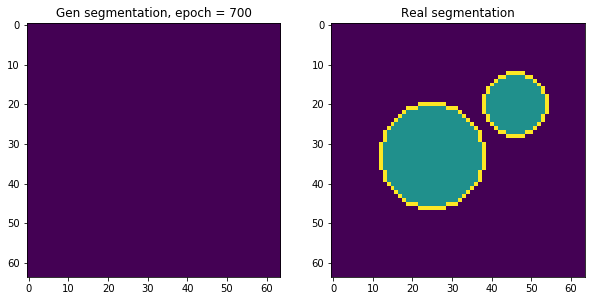

epoch - 700, loss - 3.83411693573
epoch - 701, loss - 3.82928133011
epoch - 702, loss - 3.82870006561
epoch - 703, loss - 3.8300652504
epoch - 704, loss - 3.82829904556
epoch - 705, loss - 3.82447576523
epoch - 706, loss - 3.82293248177
epoch - 707, loss - 3.82350111008
epoch - 708, loss - 3.82361865044
epoch - 709, loss - 3.8218460083
epoch - 710, loss - 3.81933522224
epoch - 711, loss - 3.81720376015
epoch - 712, loss - 3.81606817245
epoch - 713, loss - 3.81521248817
epoch - 714, loss - 3.81466960907
epoch - 715, loss - 3.81388568878
epoch - 716, loss - 3.81222486496
epoch - 717, loss - 3.81036496162
epoch - 718, loss - 3.808583498
epoch - 719, loss - 3.80721855164
epoch - 720, loss - 3.80626487732
epoch - 721, loss - 3.80572891235
epoch - 722, loss - 3.8062005043
epoch - 723, loss - 3.80807709694
epoch - 724, loss - 3.80996704102
epoch - 725, loss - 3.8089621067
epoch - 726, loss - 3.80272459984
epoch - 727, loss - 3.79946565628
epoch - 728, loss - 3.7996339798
epoch - 729, loss - 3

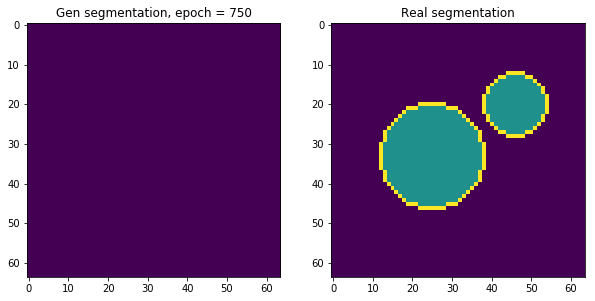

epoch - 750, loss - 3.77670526505
epoch - 751, loss - 3.77425956726
epoch - 752, loss - 3.77329659462
epoch - 753, loss - 3.77346301079
epoch - 754, loss - 3.77387022972
epoch - 755, loss - 3.7713329792
epoch - 756, loss - 3.76937842369
epoch - 757, loss - 3.7689704895
epoch - 758, loss - 3.769926548
epoch - 759, loss - 3.7712931633
epoch - 760, loss - 3.76980662346
epoch - 761, loss - 3.77046608925
epoch - 762, loss - 3.77142000198
epoch - 763, loss - 3.7669262886
epoch - 764, loss - 3.7650988102
epoch - 765, loss - 3.76298046112
epoch - 766, loss - 3.76065778732
epoch - 767, loss - 3.75877642632
epoch - 768, loss - 3.75819969177
epoch - 769, loss - 3.75853157043
epoch - 770, loss - 3.75668239594
epoch - 771, loss - 3.75614500046
epoch - 772, loss - 3.75612783432
epoch - 773, loss - 3.75625967979
epoch - 774, loss - 3.7586710453
epoch - 775, loss - 3.76081228256
epoch - 776, loss - 3.75601649284
epoch - 777, loss - 3.7507109642
epoch - 778, loss - 3.75074720383
epoch - 779, loss - 3.7

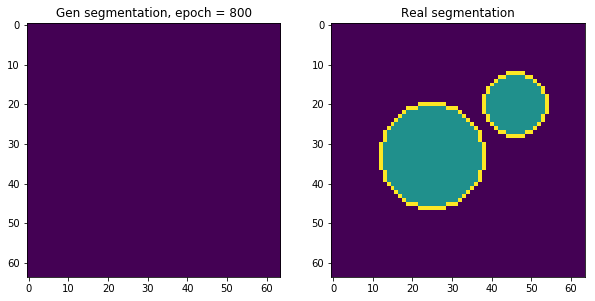

epoch - 800, loss - 3.73652172089
epoch - 801, loss - 3.73049259186
epoch - 802, loss - 3.73679804802
epoch - 803, loss - 3.72796988487
epoch - 804, loss - 3.73210954666
epoch - 805, loss - 3.72448372841
epoch - 806, loss - 3.72430562973
epoch - 807, loss - 3.72295308113
epoch - 808, loss - 3.72191905975
epoch - 809, loss - 3.72110795975
epoch - 810, loss - 3.71876454353
epoch - 811, loss - 3.71999144554
epoch - 812, loss - 3.71817016602
epoch - 813, loss - 3.72218728065
epoch - 814, loss - 3.71716547012
epoch - 815, loss - 3.71747517586
epoch - 816, loss - 3.71567678452
epoch - 817, loss - 3.71345829964
epoch - 818, loss - 3.71304655075
epoch - 819, loss - 3.71149587631
epoch - 820, loss - 3.71181154251
epoch - 821, loss - 3.70968008041
epoch - 822, loss - 3.70743846893
epoch - 823, loss - 3.7082362175
epoch - 824, loss - 3.70698618889
epoch - 825, loss - 3.70531177521
epoch - 826, loss - 3.70414590836
epoch - 827, loss - 3.70389413834
epoch - 828, loss - 3.70411610603
epoch - 829, lo

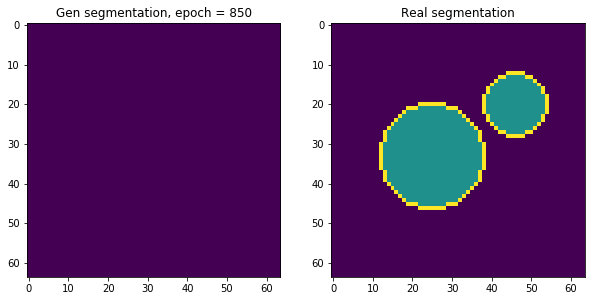

epoch - 850, loss - 3.68835425377
epoch - 851, loss - 3.69361329079
epoch - 852, loss - 3.68517303467
epoch - 853, loss - 3.67962956429
epoch - 854, loss - 3.68023538589
epoch - 855, loss - 3.67913961411
epoch - 856, loss - 3.67808914185
epoch - 857, loss - 3.67615294456
epoch - 858, loss - 3.67359828949
epoch - 859, loss - 3.67162847519
epoch - 860, loss - 3.67070150375
epoch - 861, loss - 3.66987848282
epoch - 862, loss - 3.67109584808
epoch - 863, loss - 3.67147016525
epoch - 864, loss - 3.66635227203
epoch - 865, loss - 3.66714835167
epoch - 866, loss - 3.66513204575
epoch - 867, loss - 3.66489982605
epoch - 868, loss - 3.66764259338
epoch - 869, loss - 3.66534304619
epoch - 870, loss - 3.67693853378
epoch - 871, loss - 3.68297052383
epoch - 872, loss - 3.70016241074
epoch - 873, loss - 3.67179918289
epoch - 874, loss - 3.67428803444
epoch - 875, loss - 3.67911672592
epoch - 876, loss - 3.66888093948
epoch - 877, loss - 3.6780962944
epoch - 878, loss - 3.67491841316
epoch - 879, lo

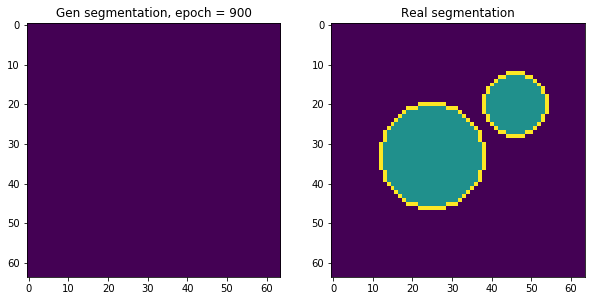

epoch - 900, loss - 3.6351518631
epoch - 901, loss - 3.63872480392
epoch - 902, loss - 3.63512516022
epoch - 903, loss - 3.63612222672
epoch - 904, loss - 3.6363503933
epoch - 905, loss - 3.63626980782
epoch - 906, loss - 3.63052010536
epoch - 907, loss - 3.62776565552
epoch - 908, loss - 3.62772893906
epoch - 909, loss - 3.6298058033
epoch - 910, loss - 3.63477516174
epoch - 911, loss - 3.64319229126
epoch - 912, loss - 3.64002656937
epoch - 913, loss - 3.63512969017
epoch - 914, loss - 3.62531161308
epoch - 915, loss - 3.63022184372
epoch - 916, loss - 3.62953090668
epoch - 917, loss - 3.62186288834
epoch - 918, loss - 3.62189292908
epoch - 919, loss - 3.62130451202
epoch - 920, loss - 3.61947011948
epoch - 921, loss - 3.62233567238
epoch - 922, loss - 3.61959075928
epoch - 923, loss - 3.62575340271
epoch - 924, loss - 3.62498760223
epoch - 925, loss - 3.61651515961
epoch - 926, loss - 3.61781430244
epoch - 927, loss - 3.61199450493
epoch - 928, loss - 3.61355090141
epoch - 929, loss

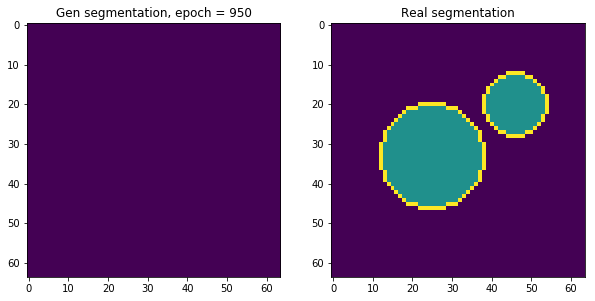

epoch - 950, loss - 3.59498929977
epoch - 951, loss - 3.59300136566
epoch - 952, loss - 3.59197020531
epoch - 953, loss - 3.60094118118
epoch - 954, loss - 3.59283185005
epoch - 955, loss - 3.5870552063
epoch - 956, loss - 3.58610129356
epoch - 957, loss - 3.58477902412
epoch - 958, loss - 3.58546805382
epoch - 959, loss - 3.58524847031
epoch - 960, loss - 3.58365631104
epoch - 961, loss - 3.58380317688
epoch - 962, loss - 3.5814344883
epoch - 963, loss - 3.58608627319
epoch - 964, loss - 3.58469676971
epoch - 965, loss - 3.57835650444
epoch - 966, loss - 3.57710528374
epoch - 967, loss - 3.57736444473
epoch - 968, loss - 3.57574462891
epoch - 969, loss - 3.57809448242
epoch - 970, loss - 3.57582402229
epoch - 971, loss - 3.5738492012
epoch - 972, loss - 3.57194828987
epoch - 973, loss - 3.57487201691
epoch - 974, loss - 3.57225131989
epoch - 975, loss - 3.57699918747
epoch - 976, loss - 3.58240318298
epoch - 977, loss - 3.57805752754
epoch - 978, loss - 3.57450485229
epoch - 979, loss

In [10]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Unet)

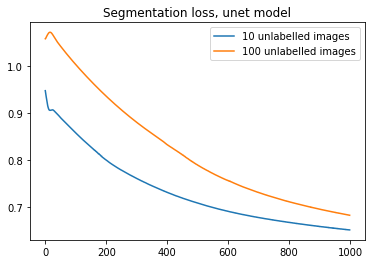

In [11]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, unet model')
plt.legend()
plt.show()

### Segmentation loss

In [ ]:
plt.plot(segmentation_loss)
plt.title('Segmentation loss on unlabelled data')
plt.xlabel('# epoch')
plt.show()

In [ ]:
print('iteration with'.format(np.argmin(segmentation_loss)))

In [ ]:
torch.save(net.state_dict(), './model-1000')

### learning

In [ ]:
plt.plot(loss_epoch)
plt.title('loss')
plt.xlabel('# epoch')
plt.show()

In [ ]:
img, segm = net(z_input)

### Results 

In [ ]:
show_image_segm(img.data.numpy(), segm.data.numpy(), 
                train_images.data.numpy(), train_segmentation.data.numpy())

### generate test batch

In [ ]:
test_batch_size = 5

In [ ]:
np.random.seed(42)
test_images, test_segmentation = predata.get_train_batch(test_batch_size)

In [ ]:
test_images = Variable(torch.from_numpy(test_images).float(), requires_grad=False)
test_segm = Variable(torch.from_numpy(test_segmentation), requires_grad=False)

In [ ]:
torch.manual_seed(42)
z_test = Variable(torch.randn(test_batch_size, 3, 64, 64), requires_grad=True)

### Optimizing only latent variable z

In [ ]:
optimizer = optim.Adam([z_test], lr=0.001)

test_loss = []
num_epochs = 1000

for epoch in range(num_epochs):
    normalize_z(z_test)
    optimizer.zero_grad()   
    img, segm = net(z_test)
    loss = 1000 * img_loss(img, test_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_test)

In [ ]:
test_img, test_segm = net(z_test)

In [ ]:
show_image_segm(test_img.data.numpy(), test_segm.data.numpy(), 
                test_images.data.numpy(), test_segmentation)